### Weibull model

<b> Goal: </b> select best neural net architecture using validation data and estimate quality of Weibull model on test data

In [1]:
import os
import sys
import pickle
from tqdm.notebook import tqdm as tqdm
import random
from functools import partial

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pycox.datasets import kkbox_v1
from sklearn.model_selection import ParameterGrid
sys.path.append("../../")

from models import kkbox_main_network
from models_hard_mining import WeibullModel
from batch_generators_hard_mining import DataGenerator
from tools import test_quality, preprocess_kkbox, transform_kkbox

In [2]:
s = 2

random.seed(s)
np.random.seed(s)
tf.set_random_seed(s)
os.environ['PYTHONHASHSEED'] = str(s)
os.environ['TF_CUDNN_DETERMINISTIC'] = str(s)

Data

In [3]:
df_train = kkbox_v1.read_df(subset='train')
df_test = kkbox_v1.read_df(subset='test')
df_val = kkbox_v1.read_df(subset='val')

x_train, t_train, y_train = preprocess_kkbox(df_train)
x_val, t_val, y_val = preprocess_kkbox(df_val)
x_test, t_test, y_test = preprocess_kkbox(df_test)

x_train, x_test, x_val = transform_kkbox(x_train, x_test, x_val)
data = {
    'train': {
        'x': x_train,
        'y': y_train,
        't': t_train
    },
    'test': {
        'x': x_test,
        'y': y_test,
        't': t_test            
    },
    'val': {
        'x': x_val,
        'y': y_val,
        't': t_val            
        }
    }

### Define hyperparameters

In [4]:
n_time_bins = 12

time_grid = np.linspace(1, np.max(data['val']['t']), 30, dtype=np.int)
inp_shape = (None, data['val']['x'].shape[1])

In [5]:
## select n_ex_bin for validation data
start_n_ex_bin = round(data['val']['x'].shape[0] / n_time_bins)

def check_n_ex_val(n_ex_bin):
    dg = ContrastiveDataGenerator(x=data['val']['x'], y=y_val, t=t_val, n_ex_bin=n_ex_bin, n_time_bins=n_time_bins)
    x_batch, y_batch_val, target_val = next(dg.get_batch()) 
    
for i in range(start_n_ex_bin, 0, -100):
    try:
        check_n_ex_val(i)
        print("Max n_ex_bin: ", i)
        break
    except StopIteration:
        print("not fiited for ", i)

not fiited for  16555
not fiited for  16455
not fiited for  16355
not fiited for  16255
not fiited for  16155
not fiited for  16055
not fiited for  15955
not fiited for  15855
not fiited for  15755
not fiited for  15655
not fiited for  15555
not fiited for  15455
not fiited for  15355
not fiited for  15255
not fiited for  15155
not fiited for  15055
not fiited for  14955
not fiited for  14855
not fiited for  14755
not fiited for  14655
not fiited for  14555
not fiited for  14455
not fiited for  14355
not fiited for  14255
not fiited for  14155
not fiited for  14055
not fiited for  13955
not fiited for  13855
not fiited for  13755
not fiited for  13655
not fiited for  13555
not fiited for  13455
not fiited for  13355
not fiited for  13255
not fiited for  13155
not fiited for  13055
not fiited for  12955
not fiited for  12855
not fiited for  12755
not fiited for  12655
not fiited for  12555
not fiited for  12455
not fiited for  12355
not fiited for  12255
not fiited for  12155
not fiited

In [6]:
for i in range(5055, 0, -1):
    try:
        check_n_ex_val(i)
        print("Max n_ex_bin: ", i)
        break
    except StopIteration:
        print("not fiited for ", i)

not fiited for  5055
not fiited for  5054
not fiited for  5053
not fiited for  5052
not fiited for  5051
not fiited for  5050
Max n_ex_bin:  5049


In [5]:
val_n_ex_bin = 5049

n_ex_bin = 30
n_epochs = 30

kkbox_main_network_current = partial(kkbox_main_network, units_in_layers=[32, 16], dropout=0)

### Test 2 alpha regularization parameters - estimate which gives higher quality to use for further neural net architecture

`alpha_reg` = 1e-6

In [7]:
tf.reset_default_graph()
model = WeibullModel(input_shape=inp_shape, seed=s, main_network=kkbox_main_network_current, alpha_reg=1e-6,
                    alpha_bias_random_mean=1.0, alpha_random_stddev=3.0, beta_random_stddev=3.0)
optimizer = tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.9, beta2=0.99)
train = optimizer.minimize(model.loss)

# validation data
dg = ContrastiveDataGenerator(x=data['val']['x'], y=data['val']['y'], t=data['val']['t'], n_ex_bin=val_n_ex_bin, n_time_bins=n_time_bins)
x_batch_val, y_batch_val, target_val = next(dg.get_batch())

dg = ContrastiveDataGenerator(x=data['train']['x'], y=data['train']['y'], t=data['train']['t'], n_ex_bin=n_ex_bin, n_time_bins=n_time_bins)

hist_losses_train = []
all_pred = []
with tf.device('/GPU:0'):
    with tf.Session() as sess:
        tf.set_random_seed(s)
        init = tf.initialize_all_variables()
        sess.run(init)
        # for each epoch
        for i in tqdm(range(n_epochs)):
            # initialize generator
            gen = dg.get_batch()
            while True:
                try:
                    # get batch data
                    x_batch, y_batch, target = next(gen)
                    feed_dict = {
                        model.x: x_batch,
                        model.t: y_batch[:, 0].reshape((y_batch[:, 0].shape[0], 1)),
                        model.y: y_batch[:, 1].reshape((y_batch[:, 0].shape[0], 1)),
                        model.target: target.reshape((y_batch[:, 0].shape[0], 1))
                    }
                    # train model
                    _, l = sess.run([train, model.loss], feed_dict=feed_dict)
                except StopIteration:
                    break
            t_a, y_a, alphas_a, betas_a, mean_sq_alpha, mean_lh = sess.run([model.t, model.y, model.alphas, model.betas, model.mean_sq_alpha, model.mean_lh],
                                                   feed_dict=feed_dict)
            pred_1 = sess.run(model.o1, feed_dict={model.x: data['val']['x']})
            all_pred.append(pred_1)
            hist_losses_train.append(l)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.global_variables_initializer` instead.


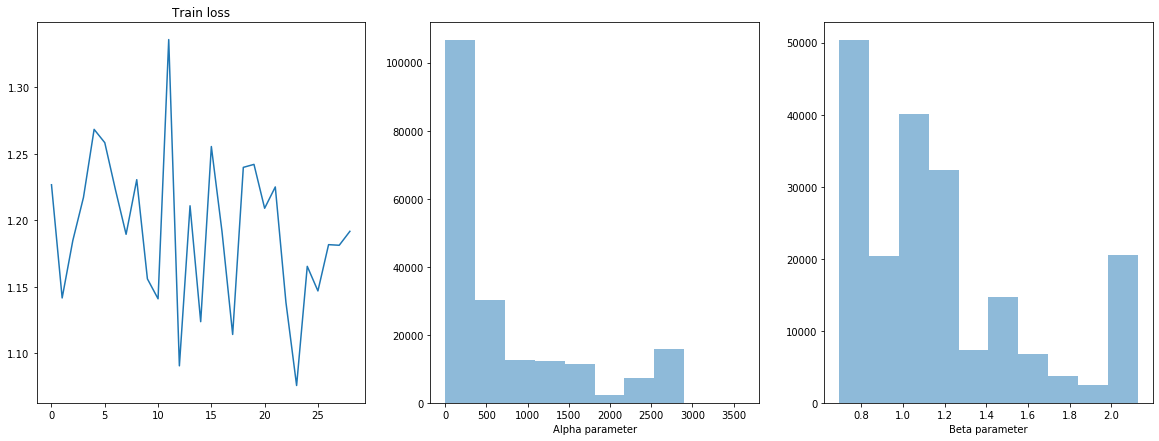

In [8]:
last_epoch_pred = all_pred[-1]

fig, ax = plt.subplots(1, 3, figsize=(20, 7))

ax[0].plot(hist_losses_train[1:])
ax[0].set_title('Train loss')

ax[1].hist(last_epoch_pred[:, 0], alpha=0.5)
ax[1].set_xlabel('Alpha parameter')

ax[2].hist(last_epoch_pred[:, 1], alpha=0.5)
ax[2].set_xlabel('Beta parameter');

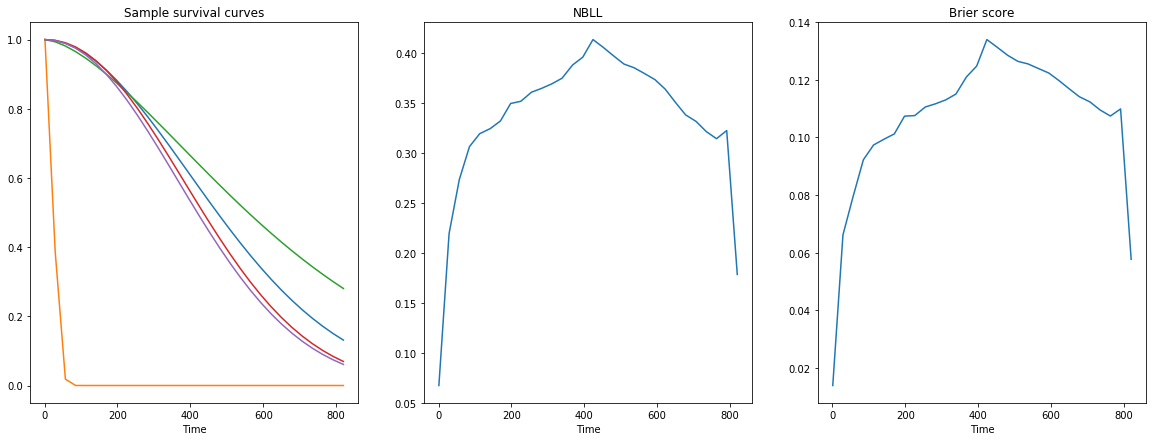

In [9]:
q = test_quality(t_true=data['val']['t'], y_true=data['val']['y'], pred=pred_1, time_grid=time_grid, concordance_at_t=424, plot=True)

In [10]:
q

,harell_c_index,dt_c_index,int_brier_score,int_nbill
0,0.836364,0.860216,0.109477,0.343763


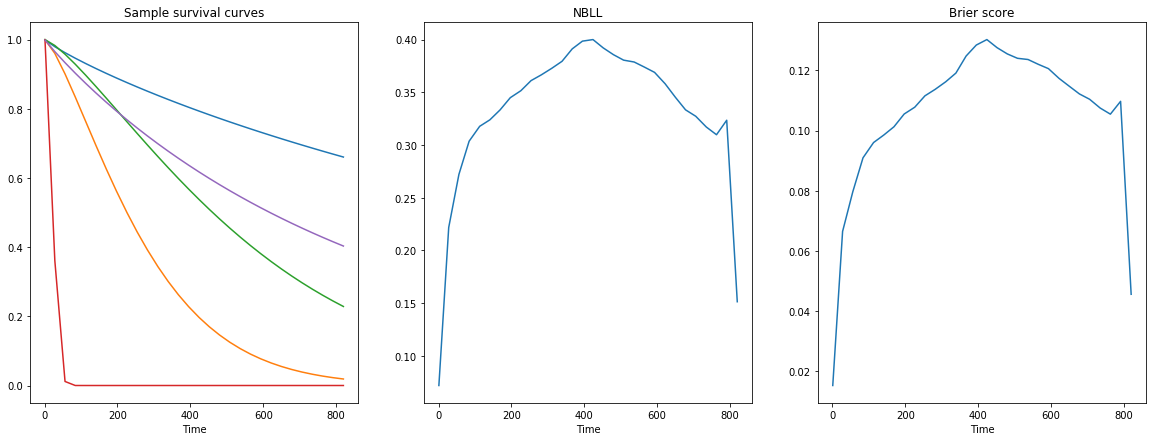

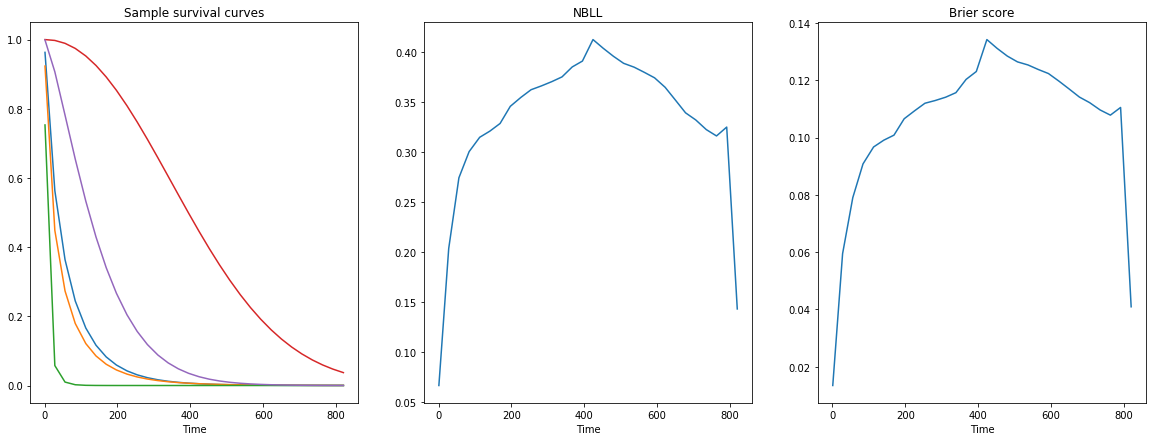

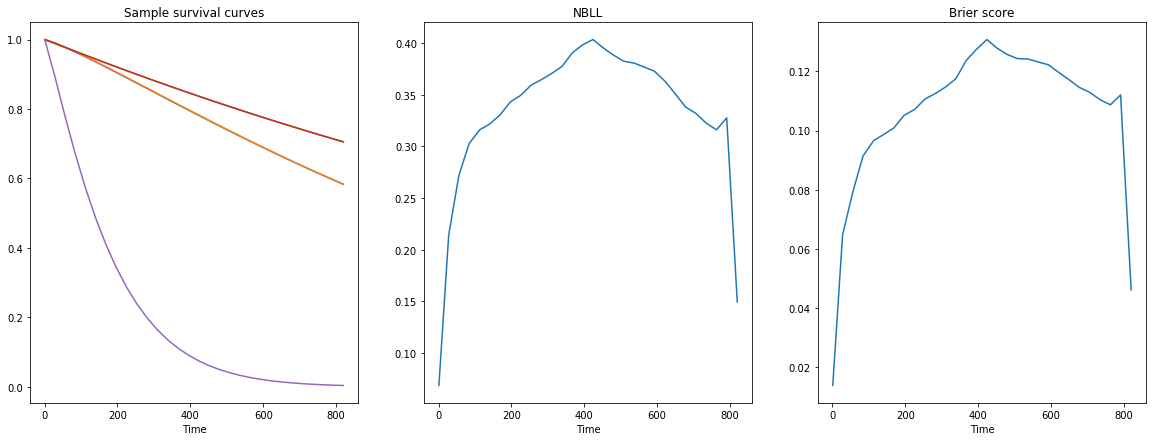

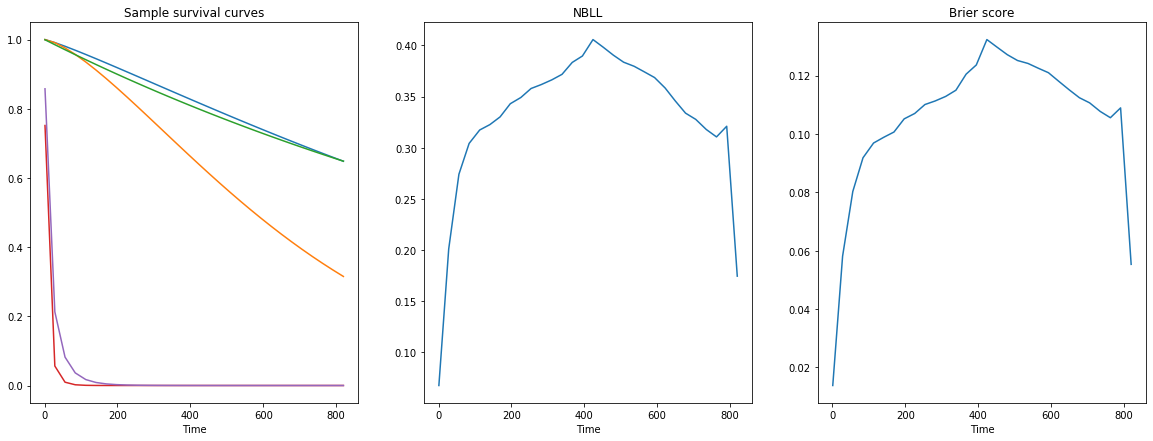

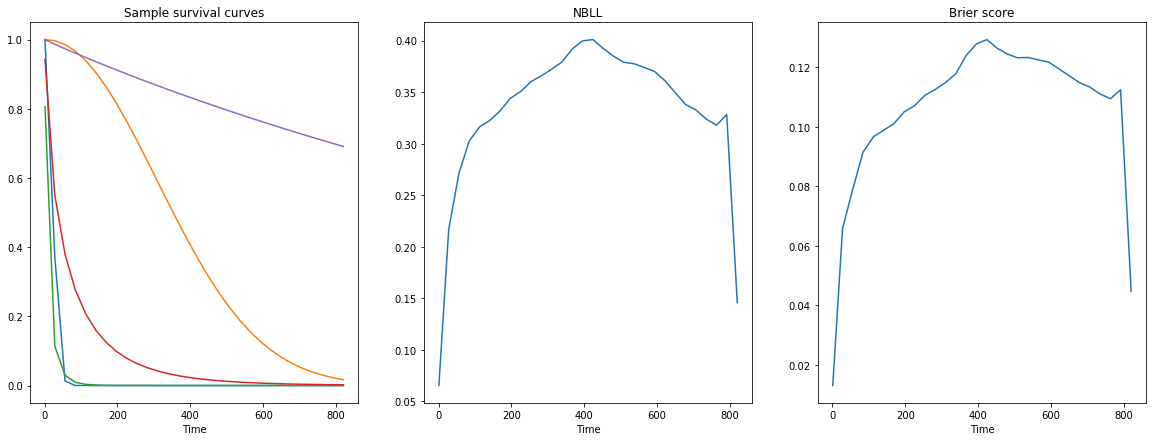

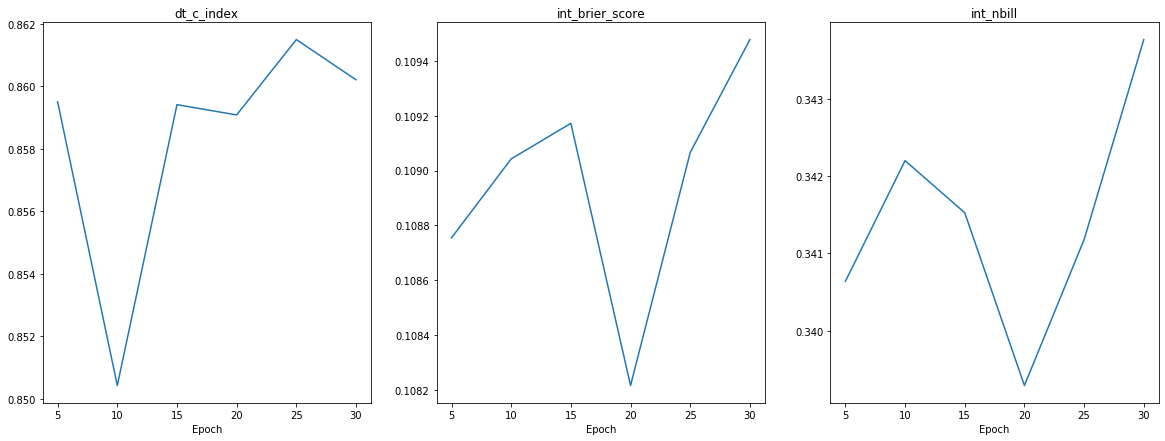

In [11]:
q['epoch'] = 30
all_q = [q]

for m in [5, 10, 15, 20, 25]:
    q = test_quality(t_true=data['val']['t'], y_true=data['val']['y'], pred=all_pred[m-1],
                 time_grid=np.array([  1,  28,  56,  84, 113, 141, 169, 197, 226, 254, 282, 311, 339,
                                     367, 395, 424, 452, 480, 508, 537, 565, 593, 622, 650, 678, 706,735, 763, 791, 820]), concordance_at_t=424, plot=True)
    q['epoch'] = m
    all_q.append(q)

df_all_q = pd.concat(all_q).sort_values('epoch')


fig, ax = plt.subplots(1, 3, figsize=(20, 7))
ax[0].plot(df_all_q['epoch'], df_all_q['dt_c_index'])
ax[0].set_xlabel('Epoch')
ax[0].set_title("dt_c_index")
ax[1].plot(df_all_q['epoch'], df_all_q['int_brier_score'])
ax[1].set_title('int_brier_score')
ax[1].set_xlabel('Epoch')
ax[2].plot(df_all_q['epoch'], df_all_q['int_nbill'])
ax[2].set_title('int_nbill')
ax[2].set_xlabel('Epoch')
plt.show();

`alpha_reg` = 1e-3

In [6]:
tf.reset_default_graph()
model = WeibullModel(input_shape=inp_shape, seed=s, main_network=kkbox_main_network_current, alpha_reg=1e-3,
                    alpha_bias_random_mean=1.0, alpha_random_stddev=3.0, beta_random_stddev=3.0)
optimizer = tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.9, beta2=0.99)
train = optimizer.minimize(model.loss)

# validation data
dg = ContrastiveDataGenerator(x=data['val']['x'], y=data['val']['y'], t=data['val']['t'], n_ex_bin=val_n_ex_bin, n_time_bins=n_time_bins)
x_batch_val, y_batch_val, target_val = next(dg.get_batch())

dg = ContrastiveDataGenerator(x=data['train']['x'], y=data['train']['y'], t=data['train']['t'], n_ex_bin=n_ex_bin, n_time_bins=n_time_bins)

hist_losses_train = []
all_pred = []
with tf.device('/GPU:0'):
    with tf.Session() as sess:
        tf.set_random_seed(s)
        init = tf.initialize_all_variables()
        sess.run(init)
        # for each epoch
        for i in tqdm(range(n_epochs)):
            # initialize generator
            gen = dg.get_batch()
            while True:
                try:
                    # get batch data
                    x_batch, y_batch, target = next(gen)
                    feed_dict = {
                        model.x: x_batch,
                        model.t: y_batch[:, 0].reshape((y_batch[:, 0].shape[0], 1)),
                        model.y: y_batch[:, 1].reshape((y_batch[:, 0].shape[0], 1)),
                        model.target: target.reshape((y_batch[:, 0].shape[0], 1))
                    }
                    # train model
                    _, l = sess.run([train, model.loss], feed_dict=feed_dict)
                except StopIteration:
                    break
            t_a, y_a, alphas_a, betas_a, mean_sq_alpha, mean_lh = sess.run([model.t, model.y, model.alphas, model.betas, model.mean_sq_alpha, model.mean_lh],
                                                   feed_dict=feed_dict)
            pred_1 = sess.run(model.o1, feed_dict={model.x: data['val']['x']})
            all_pred.append(pred_1)
            hist_losses_train.append(l)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.global_variables_initializer` instead.


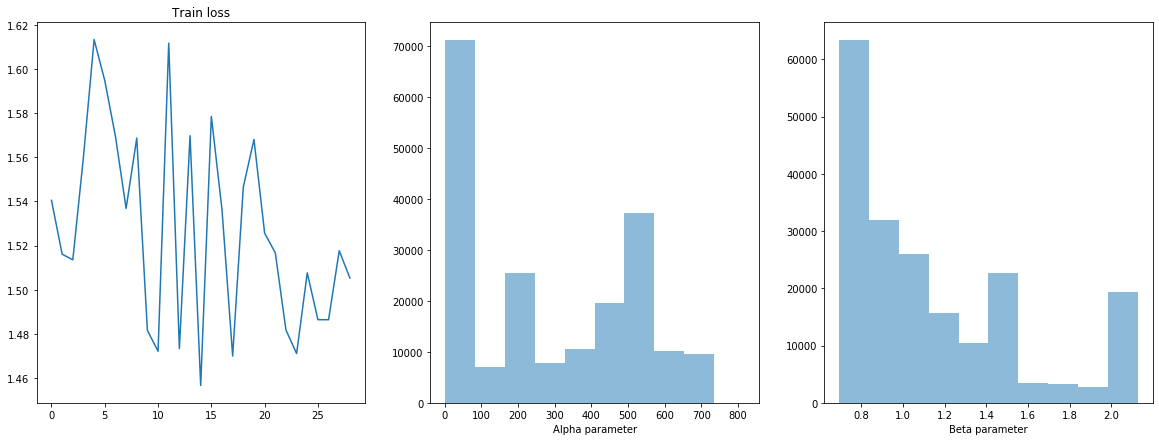

In [7]:
last_epoch_pred = all_pred[-1]

fig, ax = plt.subplots(1, 3, figsize=(20, 7))

ax[0].plot(hist_losses_train[1:])
ax[0].set_title('Train loss')

ax[1].hist(last_epoch_pred[:, 0], alpha=0.5)
ax[1].set_xlabel('Alpha parameter')

ax[2].hist(last_epoch_pred[:, 1], alpha=0.5)
ax[2].set_xlabel('Beta parameter');

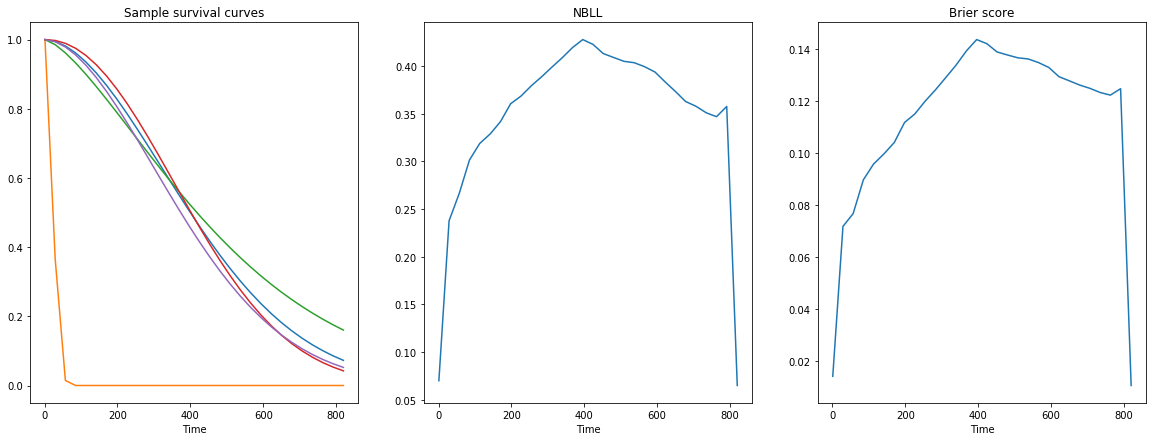

In [8]:
q = test_quality(t_true=data['val']['t'], y_true=data['val']['y'], pred=pred_1, time_grid=time_grid, concordance_at_t=424, plot=True)

In [9]:
q

,harell_c_index,dt_c_index,int_brier_score,int_nbill
0,0.838541,0.849036,0.117928,0.359773


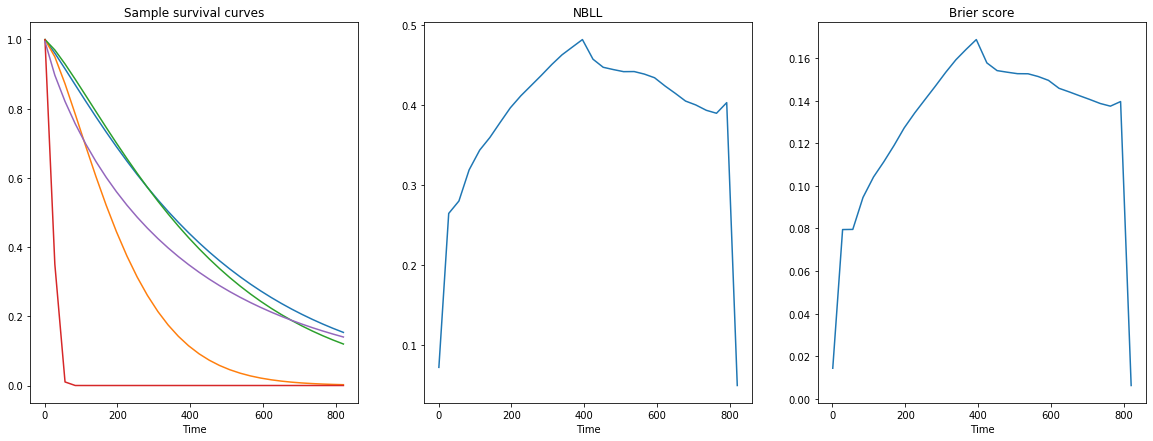

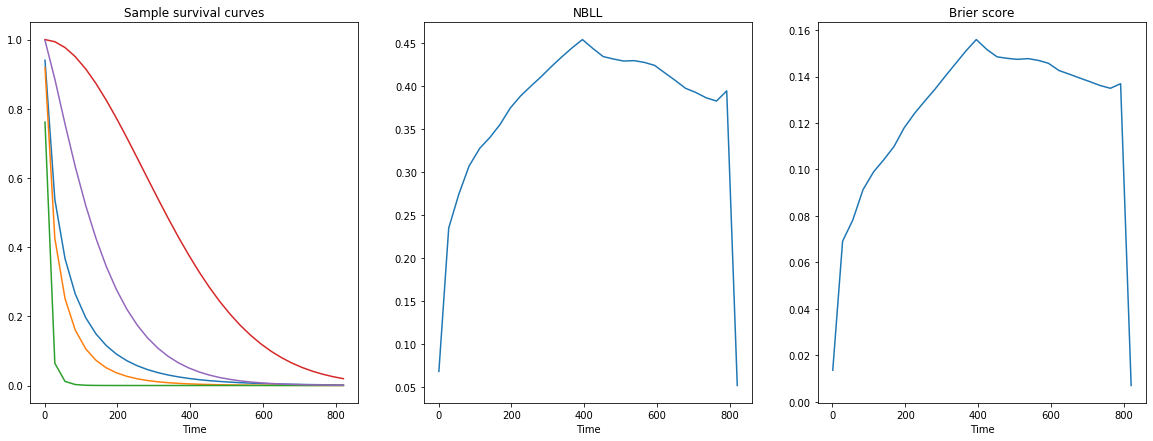

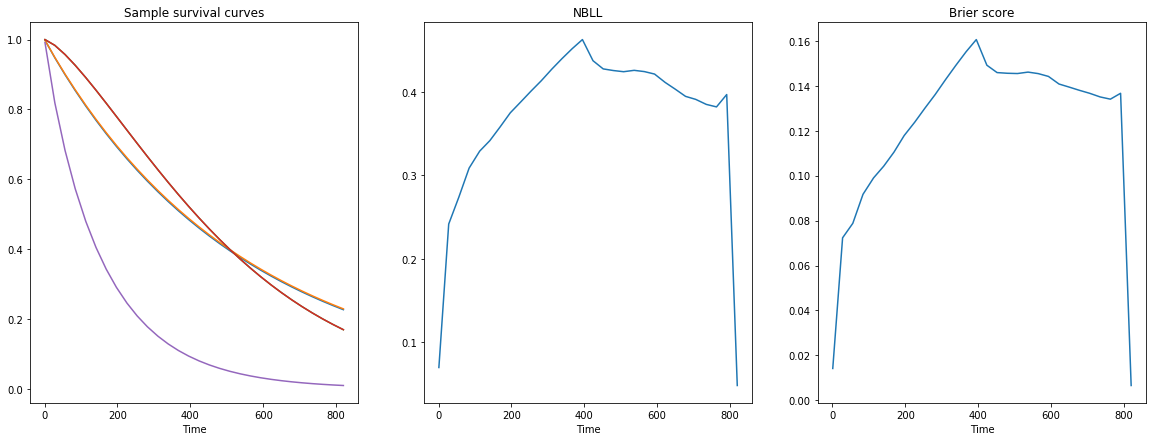

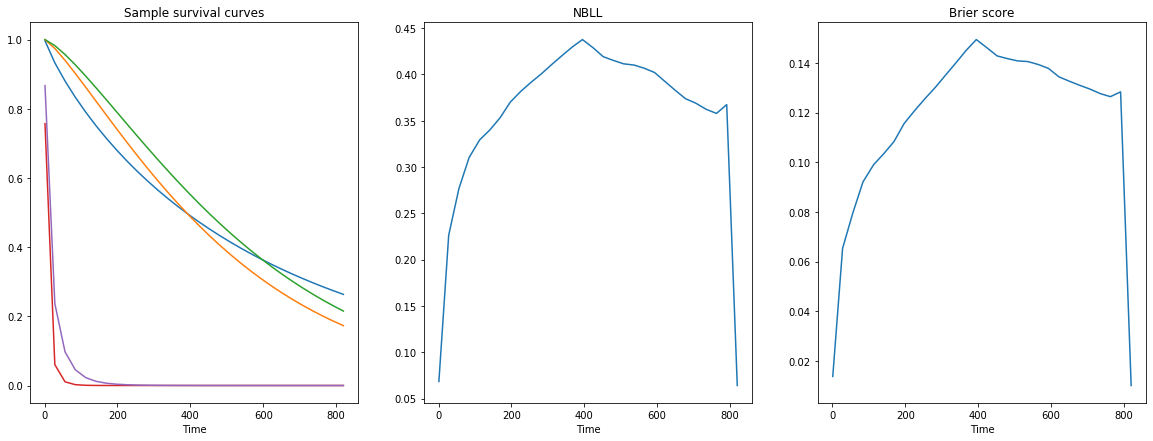

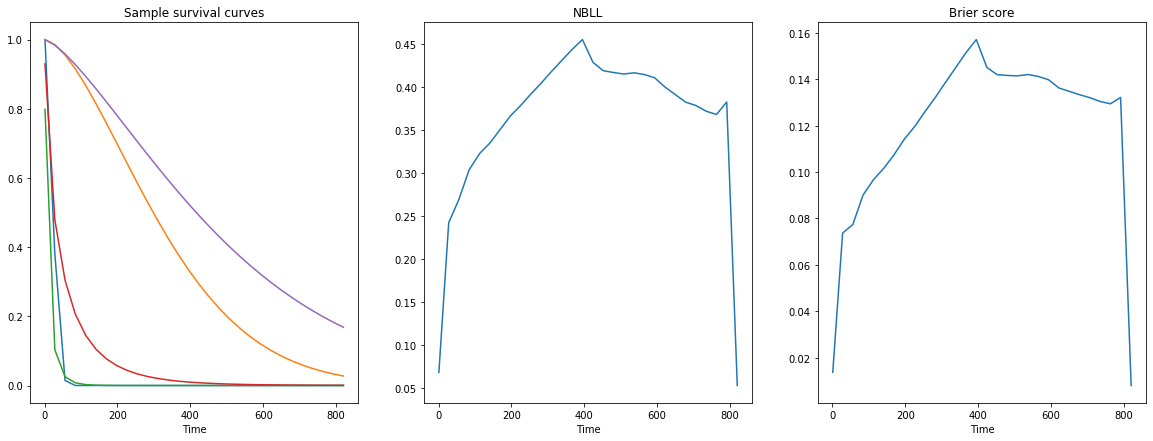

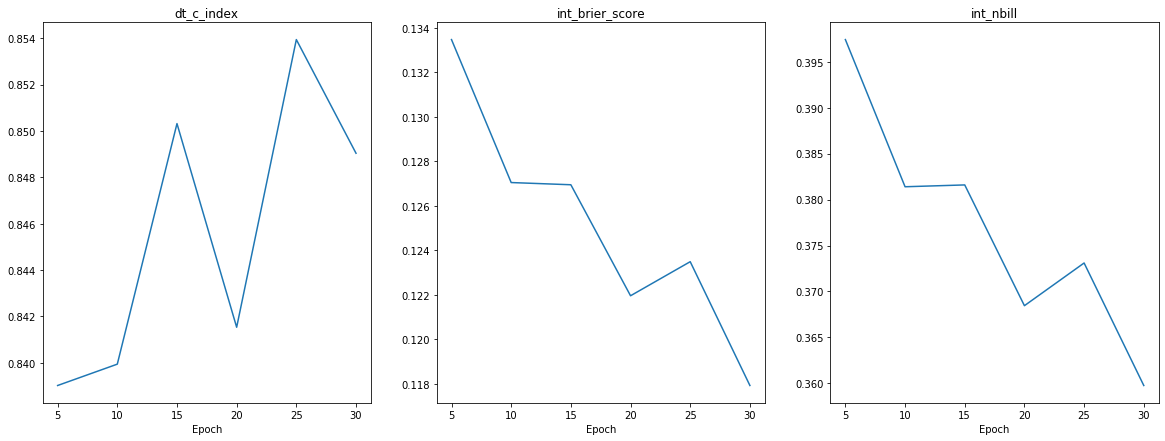

In [10]:
q['epoch'] = 30
all_q = [q]

for m in [5, 10, 15, 20, 25]:
    q = test_quality(t_true=data['val']['t'], y_true=data['val']['y'], pred=all_pred[m-1],
                 time_grid=np.array([  1,  28,  56,  84, 113, 141, 169, 197, 226, 254, 282, 311, 339,
                                     367, 395, 424, 452, 480, 508, 537, 565, 593, 622, 650, 678, 706,735, 763, 791, 820]), concordance_at_t=424, plot=True)
    q['epoch'] = m
    all_q.append(q)

df_all_q = pd.concat(all_q).sort_values('epoch')


fig, ax = plt.subplots(1, 3, figsize=(20, 7))
ax[0].plot(df_all_q['epoch'], df_all_q['dt_c_index'])
ax[0].set_xlabel('Epoch')
ax[0].set_title("dt_c_index")
ax[1].plot(df_all_q['epoch'], df_all_q['int_brier_score'])
ax[1].set_title('int_brier_score')
ax[1].set_xlabel('Epoch')
ax[2].plot(df_all_q['epoch'], df_all_q['int_nbill'])
ax[2].set_title('int_nbill')
ax[2].set_xlabel('Epoch')
plt.show();

#### With n_time_bins set to 12 and alpha_reg set to 1e-6 select best neural net architecture

In [4]:
from sklearn.model_selection import ParameterGrid
import pickle

In [12]:
model_params = {
    'inp_shape': (None, 40),
    'val_n_ex_bin': 5049,
    'n_time_bins': 12,
    'n_ex_bin': 30,
    'n_epochs': 30,
    'alpha_reg': 1e-6,
    'seed': 5,
    'time_grid': np.linspace(1, np.max(data['val']['t']), 30, dtype=np.int),
    'alpha_bias_random_mean': 1.0,
    'alpha_random_stddev': 3.0,
    'beta_random_stddev': 3.0
}
units_layers_options = [
    [64, 32, 8, 4],
    [64, 32, 32, 8],
    [32, 64, 32, 8],
    [64, 64, 32, 16],
]
dropout = [0, 0.1]

params = ParameterGrid({'units_layers': units_layers_options, 'dropout': dropout})

In [85]:
def test_model(train_data, test_data, model_params):
    kkbox_main_network_current = partial(kkbox_main_network, units_in_layers=model_params['units_layers'], dropout=model_params['dropout'])
    model = WeibullModel(input_shape=model_params['inp_shape'], seed=model_params['seed'],
                         main_network=kkbox_main_network_current, alpha_reg=model_params['alpha_reg'],
                         alpha_bias_random_mean=model_params['alpha_bias_random_mean'], 
                         alpha_random_stddev=model_params['alpha_random_stddev'], 
                         beta_random_stddev=model_params['beta_random_stddev'])
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.9, beta2=0.99)
    train = optimizer.minimize(model.loss)
    
    # data to test
    dg = ContrastiveDataGenerator(x=test_data['x'], y=test_data['y'], t=test_data['t'], n_ex_bin=model_params['val_n_ex_bin'],
                                  n_time_bins=model_params['n_time_bins'])
    x_batch_test_val, y_batch_test_val, target_test_val = next(dg.get_batch())
    dg = ContrastiveDataGenerator(x=train_data['x'], y=train_data['y'], t=train_data['t'], n_ex_bin=model_params['val_n_ex_bin'],
                                  n_time_bins=model_params['n_time_bins'])
    x_batch_test_train, y_batch_test_train, target_test_train = next(dg.get_batch())
    
    # train data
    dg = ContrastiveDataGenerator(x=train_data['x'], y=train_data['y'], t=train_data['t'], n_ex_bin=model_params['n_ex_bin'], 
                                  n_time_bins=model_params['n_time_bins'])
    
    hist_losses_train = []
    hist_losses_val = []
    all_pred_train = []
    all_pred_val = []
    with tf.device('/GPU:0'):
        with tf.Session() as sess:
            tf.set_random_seed(model_params['seed'])
            init = tf.initialize_all_variables()
            sess.run(init)
            # for each epoch
            for i in tqdm(range(model_params['n_epochs'])):
                # initialize generator
                gen = dg.get_batch()
                while True:
                    try:
                        # get batch data
                        x_batch, y_batch, target = next(gen)
                        feed_dict = {
                            model.x: x_batch,
                            model.t: y_batch[:, 0].reshape((y_batch[:, 0].shape[0], 1)),
                            model.y: y_batch[:, 1].reshape((y_batch[:, 0].shape[0], 1)),
                            model.target: target.reshape((y_batch[:, 0].shape[0], 1))
                        }
                        # train model
                        _, l = sess.run([train, model.loss], feed_dict=feed_dict)
                    except StopIteration:
                        break
                # prediction at val
                pred = sess.run(model.o1, feed_dict={model.x: test_data['x']})
                l = sess.run(model.loss, feed_dict={
                    model.x: x_batch_test_val,
                    model.t: y_batch_test_val[:, 0].reshape((y_batch_test_val[:, 0].shape[0], 1)),
                    model.y: y_batch_test_val[:, 1].reshape((y_batch_test_val[:, 0].shape[0], 1)),
                    model.target: target_test_val.reshape((y_batch_test_val[:, 0].shape[0], 1))
                })
                all_pred_val.append(pred)
                hist_losses_val.append(l)
                # prediction at train
                pred = sess.run(model.o1, feed_dict={model.x: train_data['x']})
                l = sess.run(model.loss, feed_dict={
                    model.x: x_batch_test_train,
                    model.t: y_batch_test_train[:, 0].reshape((y_batch_test_train[:, 0].shape[0], 1)),
                    model.y: y_batch_test_train[:, 1].reshape((y_batch_test_train[:, 0].shape[0], 1)),
                    model.target: target_test_train.reshape((y_batch_test_train[:, 0].shape[0], 1))
                })
                all_pred_train.append(pred)
                hist_losses_train.append(l)     
                print(l)
                
    return hist_losses_train, hist_losses_val, all_pred_train, all_pred_val


In [14]:
all_res_quality = []

train_data = data['train']
test_data = data['val']

for par in tqdm(params):
    tf.reset_default_graph()
    par.update(model_params)
    train_loss, val_loss, pred_train, pred_val = test_model(train_data=train_data, test_data=test_data, model_params=par)
    # val quality
    q = test_quality(t_true=test_data['t'], y_true=test_data['y'], pred=pred_val[-1], time_grid=model_params['time_grid'], concordance_at_t=424, plot=False)
    q['loss'] = [val_loss]
    q['train_loss'] = [train_loss]
    q['dropout'] = par['dropout']
    q['units_layers'] = [par['units_layers']]
    all_res_quality.append(q)
    with open('../../output/kkbox_weibull_0.pkl', 'wb') as f:
        pickle.dump(all_res_quality, f)

In [31]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt

In [104]:
df = pd.concat(all_res_quality).reset_index(drop=True)
def get_mean_last_loss(x):
    return np.mean(np.array(x[-5:]))
df['train_loss_last'] = df['train_loss'].apply(get_mean_last_loss)
df['val_loss_last'] = df['loss'].apply(get_mean_last_loss)

In [106]:
df

,dropout,dt_c_index,harell_c_index,int_brier_score,int_nbill,loss,train_loss,units_layers,train_loss_last,val_loss_last
0,0.0,0.860189,0.833125,0.108081,0.338631,"[1.3299954, 1.2276706, 1.216608, 1.2131957, 1....","[1.3272674, 1.2242078, 1.211525, 1.2039645, 1....","[64, 32, 8, 4]",1.172194,1.177586
1,0.0,0.860293,0.832480,0.108305,0.340329,"[1.2532356, 1.2206117, 1.2105271, 1.2118087, 1...","[1.2489358, 1.2169042, 1.2042851, 1.203473, 1....","[64, 32, 32, 8]",1.169651,1.176135
2,0.0,0.860405,0.842543,0.108412,0.336490,"[1.2422502, 1.2182707, 1.2113031, 1.2058325, 1...","[1.2411978, 1.2168623, 1.2090204, 1.2032017, 1...","[32, 64, 32, 8]",1.187098,1.190898
3,0.0,0.853076,0.836824,0.108252,0.339730,"[1.2500236, 1.2193677, 1.2092936, 1.2066318, 1...","[1.2454054, 1.2112772, 1.2030307, 1.2004379, 1...","[64, 64, 32, 16]",1.151372,1.156333
4,0.1,0.832713,0.828072,0.116082,0.360064,"[4.858452, 2.4223843, 1.7560717, 1.5872493, 1....","[4.8864474, 2.4309988, 1.7437655, 1.5807046, 1...","[64, 32, 32, 8]",1.215657,1.228100
5,0.1,0.855050,0.855077,0.117810,0.365506,"[4.5706024, 4.4292397, 1.7901727, 1.6025455, 1...","[4.6185007, 4.4041452, 1.7741283, 1.5902553, 1...","[32, 64, 32, 8]",1.363972,1.368099
6,0.1,0.856970,0.856974,0.117563,0.363938,"[1.7416297, 1.5601456, 1.4902062, 1.4459074, 1...","[1.7415322, 1.5496391, 1.4857024, 1.4407194, 1...","[64, 64, 32, 16]",1.358748,1.363264
7,0.1,0.841951,0.845447,0.122543,0.379031,"[2.7614872, 2.3009226, 1.9926282, 1.651605, 1....","[2.754726, 2.3227165, 1.9933758, 1.6540028, 1....","[64, 32, 8, 4]",1.396134,1.399227


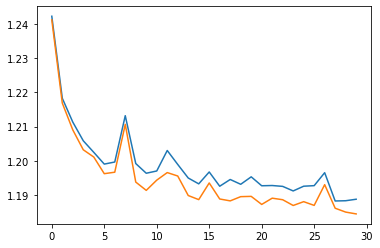

In [47]:
plt.plot(df.loc[2, 'loss'])
plt.plot(df.loc[2, 'train_loss'])

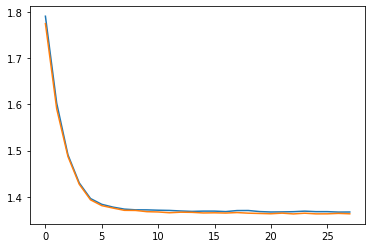

In [48]:
plt.plot(df.loc[5, 'loss'][2:])
plt.plot(df.loc[5, 'train_loss'][2:])

In [107]:
df.to_csv('../../output/kkbox_select_architecture.csv')

#### With best neural net architecture select check out which number of epochs is needed and which optimizer is better

 - Run for bigger number of epochs and look if it will perform better
 - Run for the same bigger number of epochs and decreasing learning rate at each 10 epochs

1 - bigger number of epochs

In [86]:
model_params = {
    'inp_shape': (None, 40),
    'val_n_ex_bin': 5049,
    'n_time_bins': 12,
    'n_ex_bin': 30,
    'n_epochs': 50,
    'alpha_reg': 1e-6,
    'seed': 5,
    'time_grid': np.linspace(1, np.max(data['val']['t']), 30, dtype=np.int),
    'alpha_bias_random_mean': 1.0,
    'alpha_random_stddev': 3.0,
    'beta_random_stddev': 3.0,
    'units_layers': [32, 64, 32, 8],
    'dropout': 0
}

In [87]:
tf.reset_default_graph()
train_loss, val_loss, pred_train, pred_val = test_model(train_data=train_data, test_data=test_data, model_params=model_params)
q = test_quality(t_true=test_data['t'], y_true=test_data['y'], pred=pred_val[-1], time_grid=model_params['time_grid'], concordance_at_t=424, plot=False)
q['loss'] = [val_loss]
q['train_loss'] = [train_loss]

1.2412993
1.2141438
1.2086835
1.203388
1.2029158
1.1947551
1.1975247
1.2097644
1.193355
1.1924756
1.1911981
1.1987162
1.1940958
1.1923605
1.1882844
1.1949604
1.1898211
1.1867292
1.1906646
1.1904657
1.1895475
1.192061
1.1889138
1.1878357
1.1865549
1.1861414
1.186348
1.1865025
1.1830069
1.1819602
1.1712905
1.1772618
1.1717572
1.1272526
1.1405439
1.1344845
1.1294866
1.1298066
1.1309917
1.1267718
1.1247504
1.1282011
1.132151
1.1310817
1.1256093
1.1365063
1.1356559
1.1511393
1.1325866
1.1316531



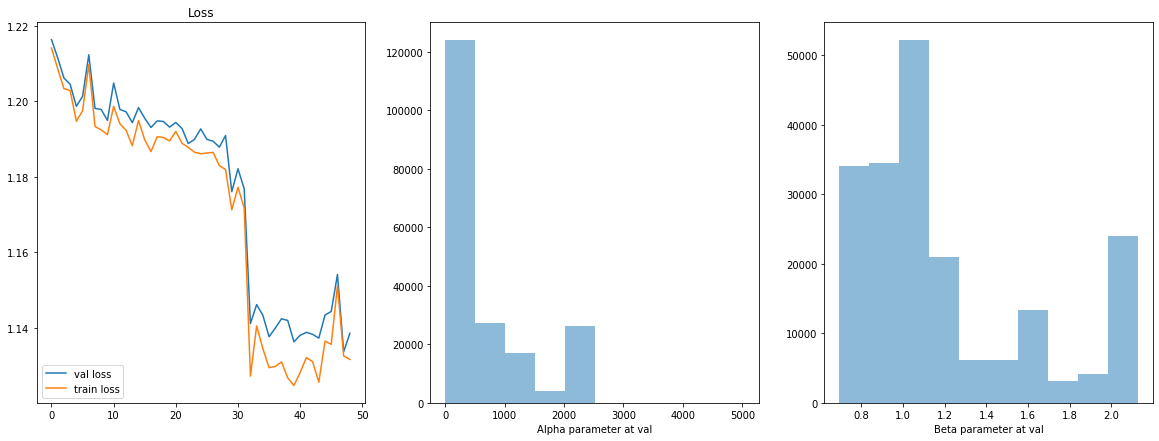

In [93]:
last_epoch_pred = pred_val[-1]

fig, ax = plt.subplots(1, 3, figsize=(20, 7))

ax[0].plot(val_loss[1:],label='val loss')
ax[0].plot(train_loss[1:], label='train loss')
ax[0].legend(loc=3)
ax[0].set_title('Loss')

ax[1].hist(last_epoch_pred[:, 0], alpha=0.5)
ax[1].set_xlabel('Alpha parameter at val')

ax[2].hist(last_epoch_pred[:, 1], alpha=0.5)
ax[2].set_xlabel('Beta parameter at val');

In [94]:
q

,harell_c_index,dt_c_index,int_brier_score,int_nbill,loss,train_loss
0,0.837593,0.851392,0.107914,0.337965,"[1.2410707, 1.2163949, 1.2115545, 1.2062157, 1...","[1.2412993, 1.2141438, 1.2086835, 1.203388, 1...."


In [101]:
q['train_loss'].apply(get_mean_last_loss)[0]

1.1375081539154053

In [102]:
q['loss'].apply(get_mean_last_loss)[0]

1.1428457498550415

/home/islam/anaconda3/envs/pycox/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


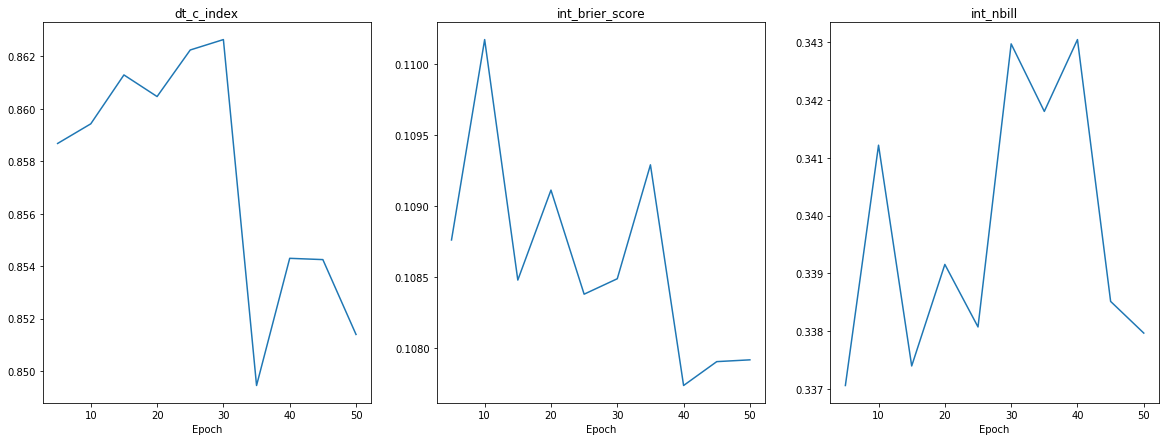

In [110]:
q['epoch'] = model_params['n_epochs']
all_q = [q]

for m in np.arange(5, model_params['n_epochs'], step=5):
    q = test_quality(t_true=test_data['t'], y_true=test_data['y'], pred=pred_val[m-1], time_grid=model_params['time_grid'], concordance_at_t=424, plot=False)
    q['epoch'] = m
    all_q.append(q)

df_all_q = pd.concat(all_q).sort_values('epoch')

fig, ax = plt.subplots(1, 3, figsize=(20, 7))
ax[0].plot(df_all_q['epoch'], df_all_q['dt_c_index'])
ax[0].set_xlabel('Epoch')
ax[0].set_title("dt_c_index")
ax[1].plot(df_all_q['epoch'], df_all_q['int_brier_score'])
ax[1].set_title('int_brier_score')
ax[1].set_xlabel('Epoch')
ax[2].plot(df_all_q['epoch'], df_all_q['int_nbill'])
ax[2].set_title('int_nbill')
ax[2].set_xlabel('Epoch')
plt.show();

In [111]:
model_params = {
    'inp_shape': (None, 40),
    'val_n_ex_bin': 5049,
    'n_time_bins': 12,
    'n_ex_bin': 30,
    'n_epochs': 50,
    'alpha_reg': 1e-6,
    'seed': 5,
    'time_grid': np.linspace(1, np.max(data['val']['t']), 30, dtype=np.int),
    'alpha_bias_random_mean': 1.0,
    'alpha_random_stddev': 5.0,
    'beta_random_stddev': 3.0,
    'units_layers': [64, 64, 32, 16],
    'dropout': 0
}

In [112]:
tf.reset_default_graph()
train_loss, val_loss, pred_train, pred_val = test_model(train_data=train_data, test_data=test_data, model_params=model_params)
q = test_quality(t_true=test_data['t'], y_true=test_data['y'], pred=pred_val[-1], time_grid=model_params['time_grid'], concordance_at_t=424, plot=False)
q['loss'] = [val_loss]
q['train_loss'] = [train_loss]

1.2288013
1.2089477
1.2288907
1.1961521
1.193099
1.1772926
1.1763678
1.1960667
1.1577138
1.1544069
1.1605611
1.1660957
1.1599573
1.2679061
1.1545179
1.1594137
1.1548333
1.1660228
1.1323068
1.139256
1.1306235
1.1273186
1.1258856
1.1335965
1.1382251
1.1263844
1.1247935
1.1279346
1.1294497
1.1273639
1.1269382
1.1307656
1.140077
1.1311965
1.1308296
1.1269728
1.1248608
1.1275554
1.1257064
1.122649
1.1212596
1.1262538
1.1254746
1.1235944
1.1395619
1.1343082
1.1251744
1.1308755
1.1281548
1.1261908



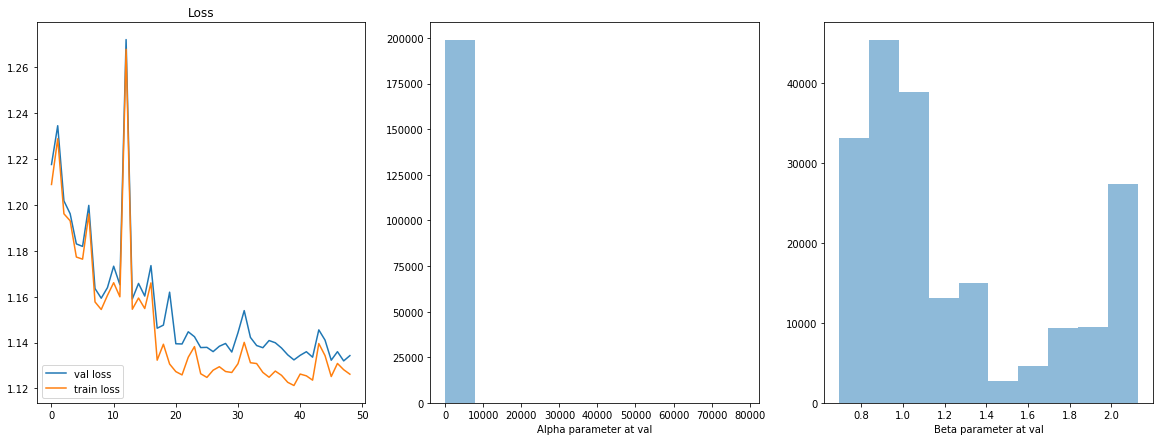

In [113]:
last_epoch_pred = pred_val[-1]

fig, ax = plt.subplots(1, 3, figsize=(20, 7))

ax[0].plot(val_loss[1:],label='val loss')
ax[0].plot(train_loss[1:], label='train loss')
ax[0].legend(loc=3)
ax[0].set_title('Loss')

ax[1].hist(last_epoch_pred[:, 0], alpha=0.5)
ax[1].set_xlabel('Alpha parameter at val')

ax[2].hist(last_epoch_pred[:, 1], alpha=0.5)
ax[2].set_xlabel('Beta parameter at val');

In [114]:
q

,harell_c_index,dt_c_index,int_brier_score,int_nbill,loss,train_loss
0,0.83871,0.851748,0.107778,0.338152,"[1.2341666, 1.21766, 1.2345725, 1.2017841, 1.1...","[1.2288013, 1.2089477, 1.2288907, 1.1961521, 1..."


In [115]:
q['train_loss'].apply(get_mean_last_loss)[0]

1.1289407014846802

In [116]:
q['loss'].apply(get_mean_last_loss)[0]

1.1351317167282104

/home/islam/anaconda3/envs/pycox/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


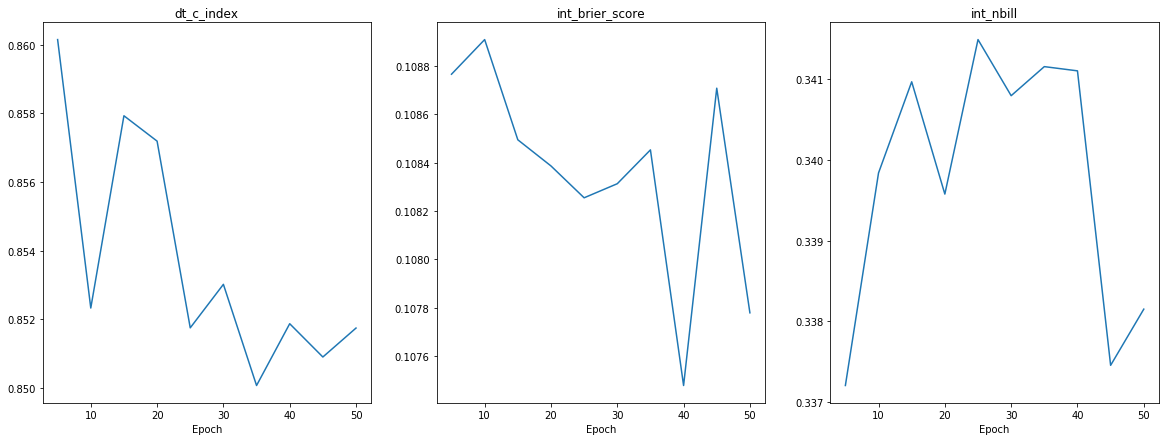

In [117]:
q['epoch'] = model_params['n_epochs']
all_q = [q]

for m in np.arange(5, model_params['n_epochs'], step=5):
    q = test_quality(t_true=test_data['t'], y_true=test_data['y'], pred=pred_val[m-1], time_grid=model_params['time_grid'], concordance_at_t=424, plot=False)
    q['epoch'] = m
    all_q.append(q)

df_all_q = pd.concat(all_q).sort_values('epoch')

fig, ax = plt.subplots(1, 3, figsize=(20, 7))
ax[0].plot(df_all_q['epoch'], df_all_q['dt_c_index'])
ax[0].set_xlabel('Epoch')
ax[0].set_title("dt_c_index")
ax[1].plot(df_all_q['epoch'], df_all_q['int_brier_score'])
ax[1].set_title('int_brier_score')
ax[1].set_xlabel('Epoch')
ax[2].plot(df_all_q['epoch'], df_all_q['int_nbill'])
ax[2].set_title('int_nbill')
ax[2].set_xlabel('Epoch')
plt.show();

2 - decaying learning rate

In [123]:
def test_model(train_data, test_data, model_params):
    kkbox_main_network_current = partial(kkbox_main_network, units_in_layers=model_params['units_layers'], dropout=model_params['dropout'])
    model = WeibullModel(input_shape=model_params['inp_shape'], seed=model_params['seed'],
                         main_network=kkbox_main_network_current, alpha_reg=model_params['alpha_reg'],
                         alpha_bias_random_mean=model_params['alpha_bias_random_mean'], 
                         alpha_random_stddev=model_params['alpha_random_stddev'], 
                         beta_random_stddev=model_params['beta_random_stddev'])
    
    step_rate = 10
    decay = 0.9
    global_step = tf.Variable(0, trainable=False)
    increment_global_step = tf.assign(global_step, global_step + 1)
    learning_rate = tf.train.exponential_decay(0.001, global_step, step_rate, decay, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    train = optimizer.minimize(model.loss)
    
    # data to test
    dg = ContrastiveDataGenerator(x=test_data['x'], y=test_data['y'], t=test_data['t'], n_ex_bin=model_params['val_n_ex_bin'],
                                  n_time_bins=model_params['n_time_bins'])
    x_batch_test_val, y_batch_test_val, target_test_val = next(dg.get_batch())
    dg = ContrastiveDataGenerator(x=train_data['x'], y=train_data['y'], t=train_data['t'], n_ex_bin=model_params['val_n_ex_bin'],
                                  n_time_bins=model_params['n_time_bins'])
    x_batch_test_train, y_batch_test_train, target_test_train = next(dg.get_batch())
    
    # train data
    dg = ContrastiveDataGenerator(x=train_data['x'], y=train_data['y'], t=train_data['t'], n_ex_bin=model_params['n_ex_bin'], 
                                  n_time_bins=model_params['n_time_bins'])
    all_lr = []
    hist_losses_train = []
    hist_losses_val = []
    all_pred_train = []
    all_pred_val = []
    with tf.device('/GPU:0'):
        with tf.Session() as sess:
            tf.set_random_seed(model_params['seed'])
            init = tf.initialize_all_variables()
            sess.run(init)
            # for each epoch
            for i in tqdm(range(model_params['n_epochs'])):
                # initialize generator
                gen = dg.get_batch()
                while True:
                    try:
                        # get batch data
                        x_batch, y_batch, target = next(gen)
                        feed_dict = {
                            model.x: x_batch,
                            model.t: y_batch[:, 0].reshape((y_batch[:, 0].shape[0], 1)),
                            model.y: y_batch[:, 1].reshape((y_batch[:, 0].shape[0], 1)),
                            model.target: target.reshape((y_batch[:, 0].shape[0], 1))
                        }
                        # train model
                        _, l = sess.run([train, model.loss], feed_dict=feed_dict)
                    except StopIteration:
                        break
                # prediction at val
                pred = sess.run(model.o1, feed_dict={model.x: test_data['x']})
                l = sess.run(model.loss, feed_dict={
                    model.x: x_batch_test_val,
                    model.t: y_batch_test_val[:, 0].reshape((y_batch_test_val[:, 0].shape[0], 1)),
                    model.y: y_batch_test_val[:, 1].reshape((y_batch_test_val[:, 0].shape[0], 1)),
                    model.target: target_test_val.reshape((y_batch_test_val[:, 0].shape[0], 1))
                })
                all_pred_val.append(pred)
                hist_losses_val.append(l)
                # prediction at train
                pred = sess.run(model.o1, feed_dict={model.x: train_data['x']})
                l = sess.run(model.loss, feed_dict={
                    model.x: x_batch_test_train,
                    model.t: y_batch_test_train[:, 0].reshape((y_batch_test_train[:, 0].shape[0], 1)),
                    model.y: y_batch_test_train[:, 1].reshape((y_batch_test_train[:, 0].shape[0], 1)),
                    model.target: target_test_train.reshape((y_batch_test_train[:, 0].shape[0], 1))
                })
                all_pred_train.append(pred)
                hist_losses_train.append(l)     
                print(l)
                new_lr = sess.run(optimizer._learning_rate_tensor)
                all_lr.append(new_lr)
                sess.run(increment_global_step)
                print(new_lr)
    return hist_losses_train, hist_losses_val, all_pred_train, all_pred_val


In [124]:
model_params = {
    'inp_shape': (None, 40),
    'val_n_ex_bin': 5049,
    'n_time_bins': 12,
    'n_ex_bin': 30,
    'n_epochs': 50,
    'alpha_reg': 1e-6,
    'seed': 5,
    'time_grid': np.linspace(1, np.max(data['val']['t']), 30, dtype=np.int),
    'alpha_bias_random_mean': 1.0,
    'alpha_random_stddev': 3.0,
    'beta_random_stddev': 3.0,
    'units_layers': [32, 64, 32, 8],
    'dropout': 0
}

In [125]:
tf.reset_default_graph()
train_loss, val_loss, pred_train, pred_val = test_model(train_data=train_data, test_data=test_data, model_params=model_params)
q = test_quality(t_true=test_data['t'], y_true=test_data['y'], pred=pred_val[-1], time_grid=model_params['time_grid'], concordance_at_t=424, plot=False)
q['loss'] = [val_loss]
q['train_loss'] = [train_loss]

1.447438
0.001
1.3856528
0.001
1.36442
0.001
1.375349
0.001
1.3400323
0.001
1.3331523
0.001
1.3251137
0.001
1.319315
0.001
1.3243337
0.001
1.3097264
0.001
1.3049896
0.00090000004
1.3046125
0.00090000004
1.2984036
0.00090000004
1.2952591
0.00090000004
1.2958392
0.00090000004
1.2923341
0.00090000004
1.29984
0.00090000004
1.2850299
0.00090000004
1.285048
0.00090000004
1.2808052
0.00090000004
1.2779645
0.00081
1.2760881
0.00081
1.2745299
0.00081
1.2748209
0.00081
1.2720002
0.00081
1.2720987
0.00081
1.2838801
0.00081
1.2679642
0.00081
1.2652618
0.00081
1.2679919
0.00081
1.2596651
0.000729
1.2583847
0.000729
1.2541342
0.000729
1.2529941
0.000729
1.2492063
0.000729
1.2463449
0.000729
1.2451335
0.000729
1.2439413
0.000729
1.2433462
0.000729
1.237004
0.000729
1.2399886
0.0006560999
1.2341421
0.0006560999
1.2344458
0.0006560999
1.2328137
0.0006560999
1.2311354
0.0006560999
1.2304239
0.0006560999
1.2291162
0.0006560999
1.2284275
0.0006560999
1.2279108
0.0006560999
1.2326442
0.0006560999



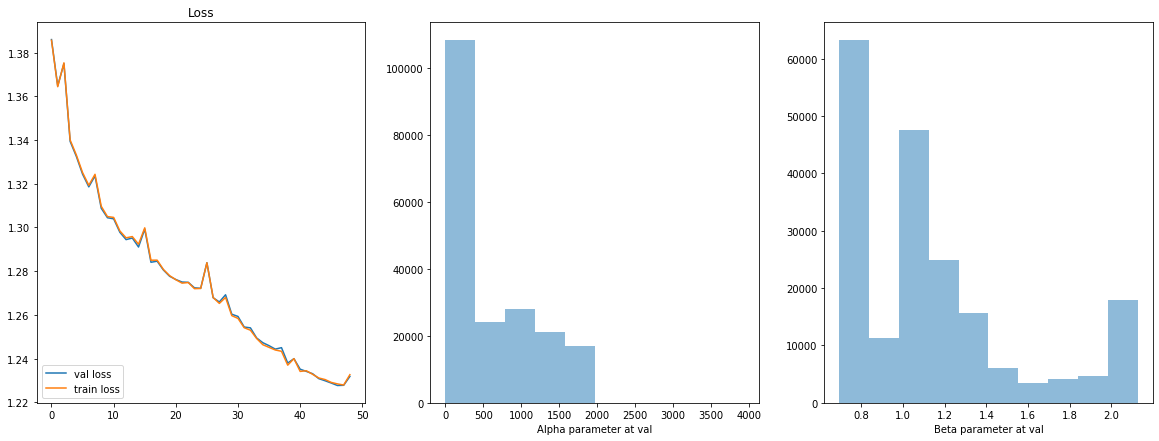

In [126]:
last_epoch_pred = pred_val[-1]

fig, ax = plt.subplots(1, 3, figsize=(20, 7))

ax[0].plot(val_loss[1:],label='val loss')
ax[0].plot(train_loss[1:], label='train loss')
ax[0].legend(loc=3)
ax[0].set_title('Loss')

ax[1].hist(last_epoch_pred[:, 0], alpha=0.5)
ax[1].set_xlabel('Alpha parameter at val')

ax[2].hist(last_epoch_pred[:, 1], alpha=0.5)
ax[2].set_xlabel('Beta parameter at val');

In [127]:
q

,harell_c_index,dt_c_index,int_brier_score,int_nbill,loss,train_loss
0,0.837044,0.853287,0.111948,0.346665,"[1.446526, 1.3859854, 1.364782, 1.3749771, 1.3...","[1.447438, 1.3856528, 1.36442, 1.375349, 1.340..."


In [128]:
q['train_loss'].apply(get_mean_last_loss)[0]

1.22970449924469

In [129]:
q['loss'].apply(get_mean_last_loss)[0]

1.229203224182129

/home/islam/anaconda3/envs/pycox/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


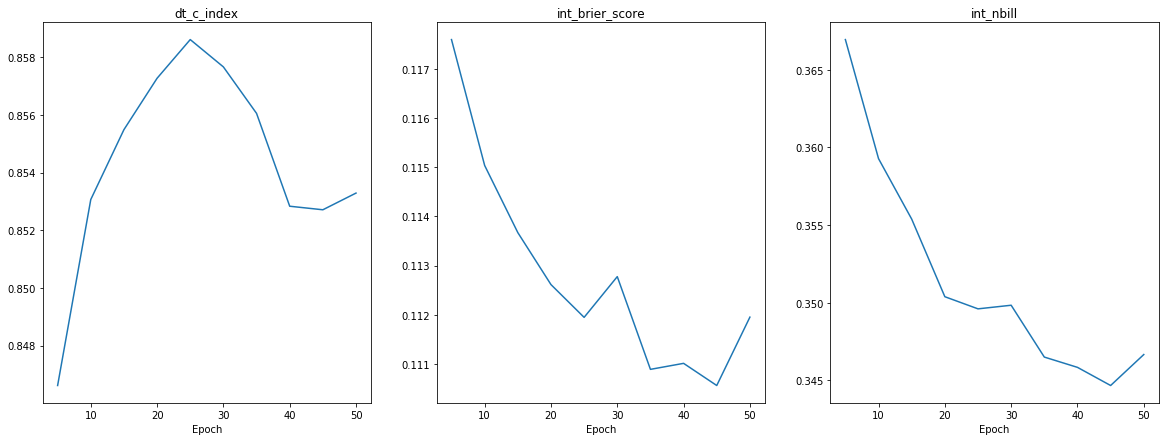

In [130]:
q['epoch'] = model_params['n_epochs']
all_q = [q]

for m in np.arange(5, model_params['n_epochs'], step=5):
    q = test_quality(t_true=test_data['t'], y_true=test_data['y'], pred=pred_val[m-1], time_grid=model_params['time_grid'], concordance_at_t=424, plot=False)
    q['epoch'] = m
    all_q.append(q)

df_all_q = pd.concat(all_q).sort_values('epoch')

fig, ax = plt.subplots(1, 3, figsize=(20, 7))
ax[0].plot(df_all_q['epoch'], df_all_q['dt_c_index'])
ax[0].set_xlabel('Epoch')
ax[0].set_title("dt_c_index")
ax[1].plot(df_all_q['epoch'], df_all_q['int_brier_score'])
ax[1].set_title('int_brier_score')
ax[1].set_xlabel('Epoch')
ax[2].plot(df_all_q['epoch'], df_all_q['int_nbill'])
ax[2].set_title('int_nbill')
ax[2].set_xlabel('Epoch')
plt.show();

In [135]:
model_params = {
    'inp_shape': (None, 40),
    'val_n_ex_bin': 5049,
    'n_time_bins': 12,
    'n_ex_bin': 30,
    'n_epochs': 50,
    'alpha_reg': 1e-6,
    'seed': 5,
    'time_grid': np.linspace(1, np.max(data['val']['t']), 30, dtype=np.int),
    'alpha_bias_random_mean': 1.0,
    'alpha_random_stddev': 7.0,
    'beta_random_stddev': 3.0,
    'units_layers': [64, 64, 32, 16],
    'dropout': 0
}

In [136]:
tf.reset_default_graph()
train_loss, val_loss, pred_train, pred_val = test_model(train_data=train_data, test_data=test_data, model_params=model_params)
q = test_quality(t_true=test_data['t'], y_true=test_data['y'], pred=pred_val[-1], time_grid=model_params['time_grid'], concordance_at_t=424, plot=False)
q['loss'] = [val_loss]
q['train_loss'] = [train_loss]

1.3684368
0.001
1.334299
0.001
1.3265722
0.001
1.3365258
0.001
1.3161247
0.001
1.3135246
0.001
1.3104337
0.001
1.306815
0.001
1.3031714
0.001
1.299087
0.001
1.2961787
0.00090000004
1.2967162
0.00090000004
1.289553
0.00090000004
1.2863793
0.00090000004
1.286333
0.00090000004
1.2829428
0.00090000004
1.2899399
0.00090000004
1.2738383
0.00090000004
1.2698162
0.00090000004
1.2742316
0.00090000004
1.2641684
0.00081
1.2622297
0.00081
1.2592614
0.00081
1.2566265
0.00081
1.2534478
0.00081
1.2510066
0.00081
1.2490418
0.00081
1.2419337
0.00081
1.2381338
0.00081
1.2356998
0.00081
1.2309803
0.000729
1.2294666
0.000729
1.2263229
0.000729
1.2240902
0.000729
1.2227007
0.000729
1.2198805
0.000729
1.2168553
0.000729
1.2153709
0.000729
1.2137358
0.000729
1.2117867
0.000729
1.2110955
0.0006560999
1.207749
0.0006560999
1.2068189
0.0006560999
1.2042073
0.0006560999
1.2036625
0.0006560999
1.2011532
0.0006560999
1.1989278
0.0006560999
1.1976628
0.0006560999
1.199201
0.0006560999
1.2040027
0.0006560999



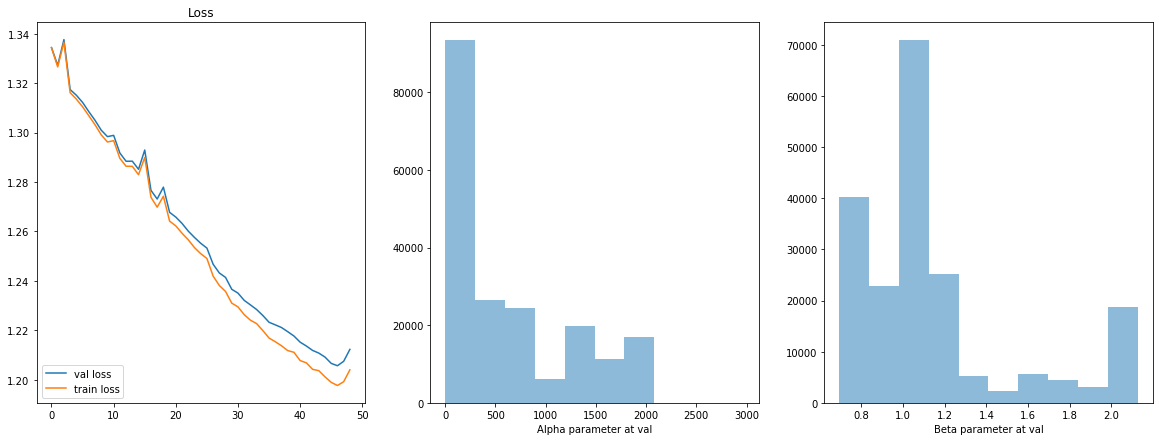

In [137]:
last_epoch_pred = pred_val[-1]

fig, ax = plt.subplots(1, 3, figsize=(20, 7))

ax[0].plot(val_loss[1:],label='val loss')
ax[0].plot(train_loss[1:], label='train loss')
ax[0].legend(loc=3)
ax[0].set_title('Loss')

ax[1].hist(last_epoch_pred[:, 0], alpha=0.5)
ax[1].set_xlabel('Alpha parameter at val')

ax[2].hist(last_epoch_pred[:, 1], alpha=0.5)
ax[2].set_xlabel('Beta parameter at val');

In [138]:
q

,harell_c_index,dt_c_index,int_brier_score,int_nbill,loss,train_loss
0,0.833552,0.859395,0.110566,0.344985,"[1.3686212, 1.334399, 1.3271863, 1.337621, 1.3...","[1.3684368, 1.334299, 1.3265722, 1.3365258, 1...."


In [139]:
q['train_loss'].apply(get_mean_last_loss)[0]

1.200189471244812

In [140]:
q['loss'].apply(get_mean_last_loss)[0]

1.2082313299179077

/home/islam/anaconda3/envs/pycox/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


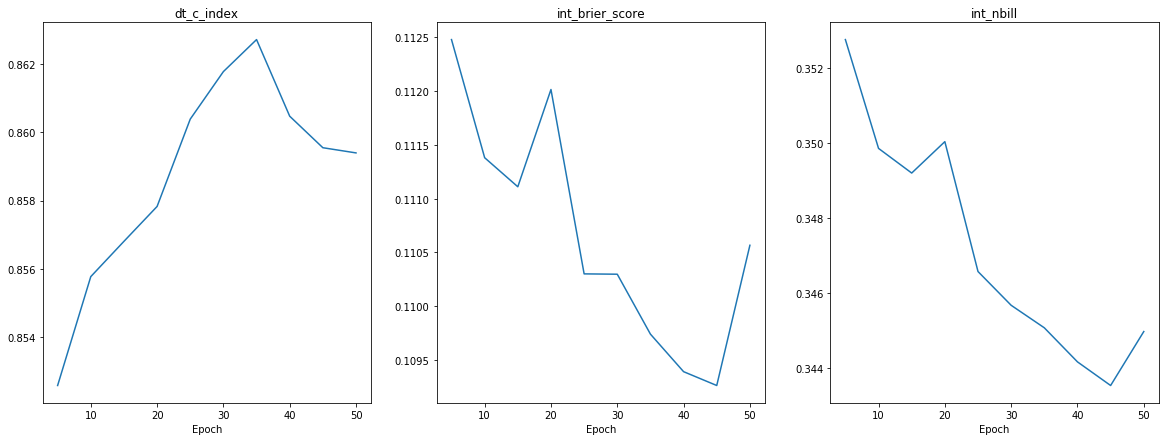

In [141]:
q['epoch'] = model_params['n_epochs']
all_q = [q]

for m in np.arange(5, model_params['n_epochs'], step=5):
    q = test_quality(t_true=test_data['t'], y_true=test_data['y'], pred=pred_val[m-1], time_grid=model_params['time_grid'], concordance_at_t=424, plot=False)
    q['epoch'] = m
    all_q.append(q)

df_all_q = pd.concat(all_q).sort_values('epoch')

fig, ax = plt.subplots(1, 3, figsize=(20, 7))
ax[0].plot(df_all_q['epoch'], df_all_q['dt_c_index'])
ax[0].set_xlabel('Epoch')
ax[0].set_title("dt_c_index")
ax[1].plot(df_all_q['epoch'], df_all_q['int_brier_score'])
ax[1].set_title('int_brier_score')
ax[1].set_xlabel('Epoch')
ax[2].plot(df_all_q['epoch'], df_all_q['int_nbill'])
ax[2].set_title('int_nbill')
ax[2].set_xlabel('Epoch')
plt.show();

In [142]:
model_params = {
    'inp_shape': (None, 40),
    'val_n_ex_bin': 5049,
    'n_time_bins': 12,
    'n_ex_bin': 30,
    'n_epochs': 50,
    'alpha_reg': 1e-6,
    'seed': 5,
    'time_grid': np.linspace(1, np.max(data['val']['t']), 30, dtype=np.int),
    'alpha_bias_random_mean': 1.0,
    'alpha_random_stddev': 3.0,
    'beta_random_stddev': 3.0,
    'units_layers': [32, 64, 32, 8],
    'dropout': 0
}

In [143]:
tf.reset_default_graph()
train_loss, val_loss, pred_train, pred_val = test_model(train_data=train_data, test_data=test_data, model_params=model_params)
q = test_quality(t_true=test_data['t'], y_true=test_data['y'], pred=pred_val[-1], time_grid=model_params['time_grid'], concordance_at_t=424, plot=False)
q['loss'] = [val_loss]
q['train_loss'] = [train_loss]

1.4475038
0.001
1.3856854
0.001
1.3644472
0.001
1.3753899
0.001
1.3400649
0.001
1.3331653
0.001
1.3251292
0.001
1.3193552
0.001
1.3243432
0.001
1.3097473
0.001
1.3049805
0.00090000004
1.3045952
0.00090000004
1.2983742
0.00090000004
1.295234
0.00090000004
1.2958697
0.00090000004
1.2923061
0.00090000004
1.2997978
0.00090000004
1.2850199
0.00090000004
1.2850333
0.00090000004
1.2807419
0.00090000004
1.2779478
0.00081
1.2760346
0.00081
1.27452
0.00081
1.2747623
0.00081
1.2719966
0.00081
1.2721125
0.00081
1.2836573
0.00081
1.2679503
0.00081
1.2652466
0.00081
1.2680401
0.00081
1.2596377
0.000729
1.2584139
0.000729
1.2541138
0.000729
1.2529483
0.000729
1.2491554
0.000729
1.2463145
0.000729
1.2449043
0.000729
1.2438589
0.000729
1.2435515
0.000729
1.2370793
0.000729
1.2399721
0.0006560999
1.2343055
0.0006560999
1.2346452
0.0006560999
1.2328568
0.0006560999
1.2311028
0.0006560999
1.2303826
0.0006560999
1.2290899
0.0006560999
1.2283851
0.0006560999
1.2278671
0.0006560999
1.2324724
0.0006560999



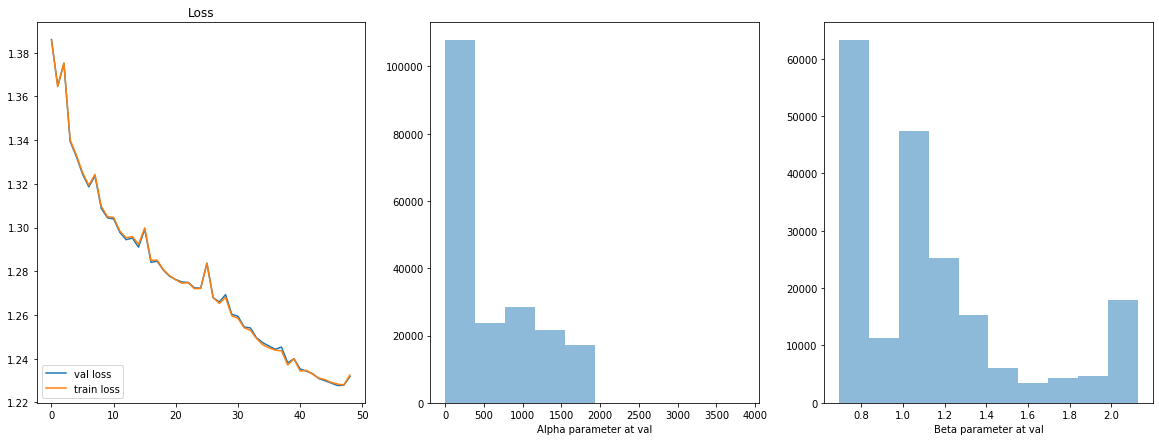

In [144]:
last_epoch_pred = pred_val[-1]

fig, ax = plt.subplots(1, 3, figsize=(20, 7))

ax[0].plot(val_loss[1:],label='val loss')
ax[0].plot(train_loss[1:], label='train loss')
ax[0].legend(loc=3)
ax[0].set_title('Loss')

ax[1].hist(last_epoch_pred[:, 0], alpha=0.5)
ax[1].set_xlabel('Alpha parameter at val')

ax[2].hist(last_epoch_pred[:, 1], alpha=0.5)
ax[2].set_xlabel('Beta parameter at val');

In [145]:
q

,harell_c_index,dt_c_index,int_brier_score,int_nbill,loss,train_loss
0,0.837083,0.853328,0.111939,0.346648,"[1.4465733, 1.3860109, 1.3647871, 1.3750203, 1...","[1.4475038, 1.3856854, 1.3644472, 1.3753899, 1..."


In [146]:
q['train_loss'].apply(get_mean_last_loss)[0]

1.2296394109725952

In [147]:
q['loss'].apply(get_mean_last_loss)[0]

1.229177474975586

/home/islam/anaconda3/envs/pycox/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


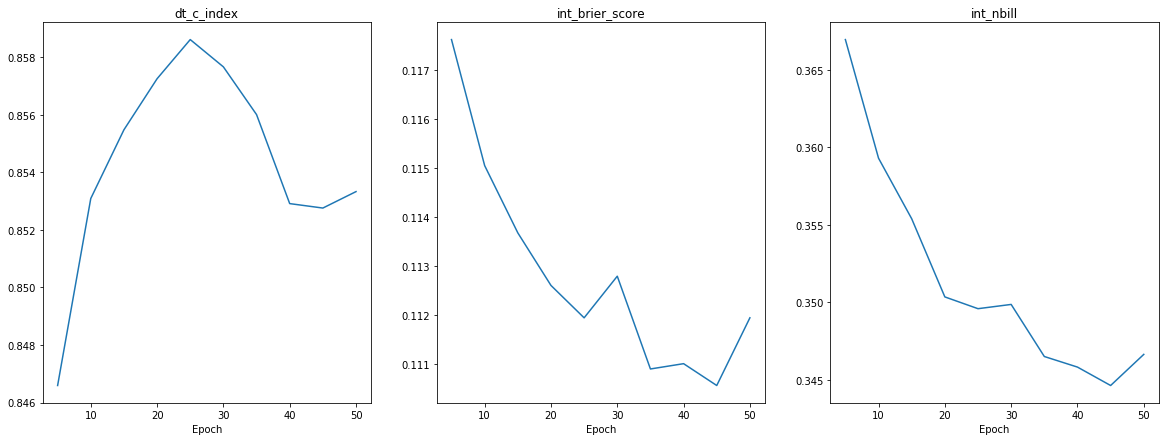

In [148]:
q['epoch'] = model_params['n_epochs']
all_q = [q]

for m in np.arange(5, model_params['n_epochs'], step=5):
    q = test_quality(t_true=test_data['t'], y_true=test_data['y'], pred=pred_val[m-1], time_grid=model_params['time_grid'], concordance_at_t=424, plot=False)
    q['epoch'] = m
    all_q.append(q)

df_all_q = pd.concat(all_q).sort_values('epoch')

fig, ax = plt.subplots(1, 3, figsize=(20, 7))
ax[0].plot(df_all_q['epoch'], df_all_q['dt_c_index'])
ax[0].set_xlabel('Epoch')
ax[0].set_title("dt_c_index")
ax[1].plot(df_all_q['epoch'], df_all_q['int_brier_score'])
ax[1].set_title('int_brier_score')
ax[1].set_xlabel('Epoch')
ax[2].plot(df_all_q['epoch'], df_all_q['int_nbill'])
ax[2].set_title('int_nbill')
ax[2].set_xlabel('Epoch')
plt.show();

In [ ]:
Fix model and optimizer - we selected it on validation data

Now train models with different alpha values and evaluate on test data

#### With best neural net architecture select optimal alpha_reg

In [169]:
## select n_ex_bin for test data

start_n_ex_bin = round(data['test']['x'].shape[0] / model_params['n_time_bins'])

def check_n_ex_val(n_ex_bin):
    dg = ContrastiveDataGenerator(x=data['test']['x'], y=data['test']['y'], t=data['test']['t'], n_ex_bin=n_ex_bin, 
                                  n_time_bins=model_params['n_time_bins'])
    x_batch, y_batch_val, target_val = next(dg.get_batch()) 
    
for i in range(start_n_ex_bin, 0, -1000):
    try:
        check_n_ex_val(i)
        print("Max n_ex_bin: ", i)
        break
    except StopIteration:
        print("not fiited for ", i)

not fiited for  55146
not fiited for  54146
not fiited for  53146
not fiited for  52146
not fiited for  51146
not fiited for  50146
not fiited for  49146
not fiited for  48146
not fiited for  47146
not fiited for  46146
not fiited for  45146
not fiited for  44146
not fiited for  43146
not fiited for  42146
not fiited for  41146
not fiited for  40146
not fiited for  39146
not fiited for  38146
not fiited for  37146
not fiited for  36146
not fiited for  35146
not fiited for  34146
not fiited for  33146
not fiited for  32146
not fiited for  31146
not fiited for  30146
not fiited for  29146
not fiited for  28146
not fiited for  27146
not fiited for  26146
not fiited for  25146
not fiited for  24146
not fiited for  23146
not fiited for  22146
not fiited for  21146
not fiited for  20146
not fiited for  19146
not fiited for  18146
not fiited for  17146
Max n_ex_bin:  16146


In [170]:
for i in range(17146, 0, -100):
    try:
        check_n_ex_val(i)
        print("Max n_ex_bin: ", i)
        break
    except StopIteration:
        print("not fiited for ", i)

not fiited for  17146
not fiited for  17046
not fiited for  16946
not fiited for  16846
not fiited for  16746
Max n_ex_bin:  16646


In [172]:
for i in range(16746, 0, -1):
    try:
        check_n_ex_val(i)
        print("Max n_ex_bin: ", i)
        break
    except StopIteration:
        print("not fiited for ", i)

not fiited for  16746
not fiited for  16745
not fiited for  16744
not fiited for  16743
not fiited for  16742
not fiited for  16741
not fiited for  16740
not fiited for  16739
not fiited for  16738
not fiited for  16737
not fiited for  16736
not fiited for  16735
not fiited for  16734
not fiited for  16733
not fiited for  16732
not fiited for  16731
not fiited for  16730
not fiited for  16729
not fiited for  16728
not fiited for  16727
not fiited for  16726
not fiited for  16725
not fiited for  16724
not fiited for  16723
not fiited for  16722
not fiited for  16721
not fiited for  16720
not fiited for  16719
not fiited for  16718
not fiited for  16717
Max n_ex_bin:  16716


In [6]:
model_params = {
    'inp_shape': (None, 40),
    'val_n_ex_bin': 16716,
    'n_time_bins': 12,
    'n_ex_bin': 30,
    'n_epochs': 50,
    'seed': 5,
    'time_grid': np.linspace(1, np.max(data['val']['t']), 30, dtype=np.int),
    'alpha_bias_random_mean': 1.0,
    'alpha_random_stddev': 7.0,
    'beta_random_stddev': 3.0,
    'units_layers': [32, 64, 32, 8],
    'dropout': 0
}
alpha_reg = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
params = ParameterGrid({'alpha_reg': alpha_reg})

In [13]:
def test_model(train_data, test_data, model_params):
    kkbox_main_network_current = partial(kkbox_main_network, units_in_layers=model_params['units_layers'], dropout=model_params['dropout'])
    model = WeibullModel(input_shape=model_params['inp_shape'], seed=model_params['seed'],
                         main_network=kkbox_main_network_current, alpha_reg=model_params['alpha_reg'],
                         alpha_bias_random_mean=model_params['alpha_bias_random_mean'], 
                         alpha_random_stddev=model_params['alpha_random_stddev'], 
                         beta_random_stddev=model_params['beta_random_stddev'])
    
    step_rate = 10
    decay = 0.9
    global_step = tf.Variable(0, trainable=False)
    increment_global_step = tf.assign(global_step, global_step + 1)
    learning_rate = tf.train.exponential_decay(0.001, global_step, step_rate, decay, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    train = optimizer.minimize(model.loss)
    
    # data to test
    dg = ContrastiveDataGenerator(x=test_data['x'], y=test_data['y'], t=test_data['t'], n_ex_bin=model_params['val_n_ex_bin'],
                                  n_time_bins=model_params['n_time_bins'])
    x_batch_test_val, y_batch_test_val, target_test_val = next(dg.get_batch())
    dg = ContrastiveDataGenerator(x=train_data['x'], y=train_data['y'], t=train_data['t'], n_ex_bin=model_params['val_n_ex_bin'],
                                  n_time_bins=model_params['n_time_bins'])
    x_batch_test_train, y_batch_test_train, target_test_train = next(dg.get_batch())
    
    # train data
    dg = ContrastiveDataGenerator(x=train_data['x'], y=train_data['y'], t=train_data['t'], n_ex_bin=model_params['n_ex_bin'], 
                                  n_time_bins=model_params['n_time_bins'])
    all_lr = []
    hist_losses_train = []
    hist_losses_val = []
    all_pred_train = []
    all_pred_val = []
    with tf.device('/GPU:0'):
        with tf.Session() as sess:
            tf.set_random_seed(model_params['seed'])
            init = tf.initialize_all_variables()
            sess.run(init)
            # for each epoch
            for i in tqdm(range(model_params['n_epochs'])):
                # initialize generator
                gen = dg.get_batch()
                while True:
                    try:
                        # get batch data
                        x_batch, y_batch, target = next(gen)
                        feed_dict = {
                            model.x: x_batch,
                            model.t: y_batch[:, 0].reshape((y_batch[:, 0].shape[0], 1)),
                            model.y: y_batch[:, 1].reshape((y_batch[:, 0].shape[0], 1)),
                            model.target: target.reshape((y_batch[:, 0].shape[0], 1)),
                        }
                        # train model
                        _, l = sess.run([train, model.loss], feed_dict=feed_dict)
                    except StopIteration:
                        break
                # prediction at val
                pred = sess.run(model.o1, feed_dict={model.x: test_data['x']})
                l = sess.run(model.loss, feed_dict={
                    model.x: x_batch_test_val,
                    model.t: y_batch_test_val[:, 0].reshape((y_batch_test_val[:, 0].shape[0], 1)),
                    model.y: y_batch_test_val[:, 1].reshape((y_batch_test_val[:, 0].shape[0], 1)),
                    model.target: target_test_val.reshape((y_batch_test_val[:, 0].shape[0], 1))
                })
                all_pred_val.append(pred)
                hist_losses_val.append(l)
                # prediction at train
                pred = sess.run(model.o1, feed_dict={model.x: train_data['x']})
                l = sess.run(model.loss, feed_dict={
                    model.x: x_batch_test_train,
                    model.t: y_batch_test_train[:, 0].reshape((y_batch_test_train[:, 0].shape[0], 1)),
                    model.y: y_batch_test_train[:, 1].reshape((y_batch_test_train[:, 0].shape[0], 1)),
                    model.target: target_test_train.reshape((y_batch_test_train[:, 0].shape[0], 1))
                })
                all_pred_train.append(pred)
                hist_losses_train.append(l)     
                print(l)
                new_lr = sess.run(optimizer._learning_rate_tensor)
                all_lr.append(new_lr)
                sess.run(increment_global_step)

    return hist_losses_train, hist_losses_val, all_pred_train, all_pred_val


In [182]:
all_res_quality = []

train_data = data['train']
test_data = data['test']

for par in tqdm(params):
    tf.reset_default_graph()
    par.update(model_params)
    train_loss, val_loss, pred_train, pred_val = test_model(train_data=train_data, test_data=test_data, model_params=par)
    q = test_quality(t_true=test_data['t'], y_true=test_data['y'], pred=pred_val[-1], time_grid=model_params['time_grid'], concordance_at_t=424, plot=False)
    q['test_loss'] = [val_loss]
    q['train_loss'] = [train_loss]
    q['alpha_reg'] = par['alpha_reg']
    all_res_quality.append(q)
    with open('../../output/kkbox_weibull_alpha.pkl', 'wb') as f:
        pickle.dump(all_res_quality, f)

1.3738222
1.3565573
1.3438535
1.3371929
1.3356284
1.325102
1.3193433
1.3158733
1.3092374
1.3004242
1.2973194
1.2902443
1.2864664
1.2863606
1.2756495
1.2694302
1.2747674
1.2675182
1.2673955
1.2544305
1.2465341
1.2424827
1.2531662
1.2441264
1.2387741
1.2313505
1.2282115
1.2290537
1.2450268
1.2277043
1.2198386
1.2184147
1.2183213
1.2239889
1.2156346
1.2147218
1.2255489
1.2124659
1.212232
1.2103581
1.2095165
1.2124901
1.2084452
1.2086804
1.2076937
1.2068663
1.2076849
1.2060237
1.2055078
1.2067957



1.3729395
1.3549811
1.3433983
1.3374878
1.3371389
1.3265113
1.3205369
1.3166318
1.3100423
1.3027846
1.2981907
1.2928927
1.288735
1.2887596
1.2774874
1.2708149
1.2717946
1.2664193
1.2615236
1.2550557
1.2494726
1.2468351
1.2482592
1.2431502
1.2410477
1.2354172
1.2328596
1.2322564
1.2359341
1.2293458
1.2230947
1.2222319
1.2204995
1.2247376
1.2181786
1.2196729
1.2304976
1.2151499
1.2164468
1.2134658
1.2131395
1.2157637
1.2115943
1.2108957
1.2107267
1.2097325
1.2102284
1.2088506
1.2075963
1.209204



1.3733683
1.3551023
1.3444254
1.3388288
1.3373343
1.32961
1.323723
1.3210886
1.3148264
1.3065957
1.302036
1.2966057
1.2926362
1.2929503
1.282083
1.2760346
1.2781135
1.2734118
1.2679766
1.2587988
1.2526083
1.2487508
1.2554747
1.2470194
1.2433366
1.2362694
1.2331833
1.2325995
1.2460493
1.23157
1.224214
1.2228825
1.222776
1.2276075
1.2193619
1.2200533
1.2301689
1.2180973
1.2159289
1.2143755
1.213897
1.2172536
1.2120512
1.2120823
1.2118797
1.2103983
1.2100314
1.2102027
1.2084203
1.2093326



1.37683
1.3616306
1.3472316
1.3414471
1.3412592
1.3312675
1.3250577
1.3221304
1.3151551
1.3075721
1.3036324
1.2979294
1.2950134
1.2945845
1.2845949
1.2789016
1.2801979
1.2769823
1.2713246
1.2640972
1.2572017
1.2536721
1.2560344
1.2507977
1.2485396
1.2418718
1.2390811
1.2400599
1.2440797
1.235932
1.2293766
1.2277508
1.2270726
1.2350612
1.2247003
1.2266104
1.2378597
1.2218755
1.2234101
1.2198347
1.2202194
1.2221249
1.2182599
1.2177068
1.2170256
1.2154833
1.216816
1.2148751
1.2132932
1.2143342



1.4123219
1.3961486
1.3835127
1.3767575
1.3764709
1.3673483
1.3639947
1.3612106
1.354658
1.349253
1.3467021
1.3413262
1.3400091
1.3420401
1.3303616
1.3260827
1.3280317
1.3304055
1.3288424
1.3126625
1.3044174
1.2999352
1.3213646
1.2992263
1.2871227
1.2904127
1.291212
1.2883936
1.307546
1.2785649
1.2701966
1.2674589
1.2662549
1.272378
1.263631
1.2640426
1.2775905
1.2594016
1.2602333
1.2576772
1.2582843
1.2564672
1.2558396
1.2564263
1.2551763
1.2533966
1.2552066
1.2543412
1.2523491
1.2534558



34.934452
34.934452
34.934452
34.934452
34.934452
34.934452
34.934452
34.934452
34.934452
34.934452
34.934452
34.934452
34.934452
34.934452
34.934452
34.934452
34.934452
34.934452
34.934452
34.934452
34.934452
34.934452
34.934452
34.934452
34.934452
34.934452
34.934452
34.934452
34.934452
34.934452
34.934452
34.934452
34.934452
34.934452
34.934452
34.934452
34.934452
34.934452
34.934452
34.934452
34.934452
34.934452
34.934452
34.934452
34.934452
34.934452
34.934452
34.934452
34.934452
34.934452



34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345



35.03345
35.03345
35.03345
35.03345
35.03345
35.03345
35.03345
35.03345
35.03345
35.03345
35.03345
35.03345
35.03345
35.03345
35.03345
35.03345
35.03345
35.03345
35.03345
35.03345
35.03345
35.03345
35.03345
35.03345
35.03345
35.03345
35.03345
35.03345
35.03345
35.03345
35.03345
35.03345
35.03345
35.03345
35.03345
35.03345
35.03345
35.03345
35.03345
35.03345
35.03345
35.03345
35.03345
35.03345
35.03345
35.03345
35.03345
35.03345
35.03345
35.03345




In [5]:
model_params = {
    'inp_shape': (None, 40),
    'val_n_ex_bin': 16716,
    'n_time_bins': 12,
    'n_ex_bin': 30,
    'n_epochs': 50,
    'seed': 5,
    'time_grid': np.linspace(1, np.max(data['val']['t']), 30, dtype=np.int),
    'alpha_bias_random_mean': 1.0,
    'alpha_random_stddev': 3.0,
    'beta_random_stddev': 3.0,
    'units_layers': [32, 64, 32, 8],
    'dropout': 0
}
alpha_reg = [1e-3, 1e-2, 1e-1, 1e-4,1e-5, 1e-6]
params = ParameterGrid({'alpha_reg': alpha_reg})

In [6]:
def test_model(train_data, test_data, model_params):
    kkbox_main_network_current = partial(kkbox_main_network, units_in_layers=model_params['units_layers'], dropout=model_params['dropout'])
    model = WeibullModel(input_shape=model_params['inp_shape'], seed=model_params['seed'],
                         main_network=kkbox_main_network_current, alpha_reg=model_params['alpha_reg'],
                         alpha_bias_random_mean=model_params['alpha_bias_random_mean'], 
                         alpha_random_stddev=model_params['alpha_random_stddev'], 
                         beta_random_stddev=model_params['beta_random_stddev'])
    
#     step_rate = 10
#     decay = 0.9
#     global_step = tf.Variable(0, trainable=False)
#     increment_global_step = tf.assign(global_step, global_step + 1)
#     learning_rate = tf.train.exponential_decay(0.001, global_step, step_rate, decay, staircase=True)
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.9, beta2=0.99)
    train = optimizer.minimize(model.loss)
    
    # data to test
    dg = ContrastiveDataGenerator(x=test_data['x'], y=test_data['y'], t=test_data['t'], n_ex_bin=model_params['val_n_ex_bin'],
                                  n_time_bins=model_params['n_time_bins'])
    x_batch_test_val, y_batch_test_val, target_test_val = next(dg.get_batch())
    dg = ContrastiveDataGenerator(x=train_data['x'], y=train_data['y'], t=train_data['t'], n_ex_bin=model_params['val_n_ex_bin'],
                                  n_time_bins=model_params['n_time_bins'])
    x_batch_test_train, y_batch_test_train, target_test_train = next(dg.get_batch())
    
    # train data
    dg = ContrastiveDataGenerator(x=train_data['x'], y=train_data['y'], t=train_data['t'], n_ex_bin=model_params['n_ex_bin'], 
                                  n_time_bins=model_params['n_time_bins'])
    all_lr = []
    hist_losses_train = []
    hist_losses_val = []
    all_pred_train = []
    all_pred_val = []
    with tf.device('/GPU:0'):
        with tf.Session() as sess:
            tf.set_random_seed(model_params['seed'])
            init = tf.initialize_all_variables()
            sess.run(init)
            # for each epoch
            for i in tqdm(range(model_params['n_epochs'])):
                # initialize generator
                gen = dg.get_batch()
                while True:
                    try:
                        # get batch data
                        x_batch, y_batch, target = next(gen)
                        feed_dict = {
                            model.x: x_batch,
                            model.t: y_batch[:, 0].reshape((y_batch[:, 0].shape[0], 1)),
                            model.y: y_batch[:, 1].reshape((y_batch[:, 0].shape[0], 1)),
                            model.target: target.reshape((y_batch[:, 0].shape[0], 1)),
                        }
                        # train model
                        _, l = sess.run([train, model.loss], feed_dict=feed_dict)
                    except StopIteration:
                        break
                # prediction at val
                pred = sess.run(model.o1, feed_dict={model.x: test_data['x']})
                l = sess.run(model.loss, feed_dict={
                    model.x: x_batch_test_val,
                    model.t: y_batch_test_val[:, 0].reshape((y_batch_test_val[:, 0].shape[0], 1)),
                    model.y: y_batch_test_val[:, 1].reshape((y_batch_test_val[:, 0].shape[0], 1)),
                    model.target: target_test_val.reshape((y_batch_test_val[:, 0].shape[0], 1))
                })
                all_pred_val.append(pred)
                hist_losses_val.append(l)
                # prediction at train
                pred = sess.run(model.o1, feed_dict={model.x: train_data['x']})
                l = sess.run(model.loss, feed_dict={
                    model.x: x_batch_test_train,
                    model.t: y_batch_test_train[:, 0].reshape((y_batch_test_train[:, 0].shape[0], 1)),
                    model.y: y_batch_test_train[:, 1].reshape((y_batch_test_train[:, 0].shape[0], 1)),
                    model.target: target_test_train.reshape((y_batch_test_train[:, 0].shape[0], 1))
                })
                all_pred_train.append(pred)
                hist_losses_train.append(l)     
                print(l)
#                 new_lr = sess.run(optimizer._learning_rate_tensor)
#                 all_lr.append(new_lr)
#                 sess.run(increment_global_step)

    return hist_losses_train, hist_losses_val, all_pred_train, all_pred_val


In [7]:
all_res_quality = []

train_data = data['train']
test_data = data['test']

for par in tqdm(params):
    tf.reset_default_graph()
    par.update(model_params)
    train_loss, val_loss, pred_train, pred_val = test_model(train_data=train_data, test_data=test_data, model_params=par)
    q = test_quality(t_true=test_data['t'], y_true=test_data['y'], pred=pred_val[-1], time_grid=model_params['time_grid'], concordance_at_t=424, plot=False)
    q['test_loss'] = [val_loss]
    q['train_loss'] = [train_loss]
    q['alpha_reg'] = par['alpha_reg']
    all_res_quality.append(q)
    with open('../../output/kkbox_weibull_alpha_0.pkl', 'wb') as f:
        pickle.dump(all_res_quality, f)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.global_variables_initializer` instead.


1.5802718
1.5371797
1.5414296
1.5329963
1.5264384
1.5265064
1.5261137
1.5299249
1.5234451
1.5235678
1.5260928
1.5222143
1.5232248
1.5076947
1.4980447
1.4981978
1.496227
1.5006484
1.5093889
1.4962041
1.4959757
1.5075759
1.4982867
1.4919208
1.494647
1.5092214
1.4692435
1.4907281
1.4706669
1.4723268
1.4672464
1.4697728
1.4716151
1.4746058
1.4764752
1.4666226
1.4717939
1.4689403
1.473895
1.469145
1.4785585
1.472127
1.4686526
1.4816624
1.4716914
1.4700186
1.4727563
1.4676523
1.4722197
1.4645042



2.6412392
2.6276598
2.628009
2.5708795
2.5670042
2.5602672
2.5595067
2.562202
2.5566864
2.5593054
2.557218
2.5669966
2.5561547
2.5572877
2.5569177
2.5564828
2.5563684
2.5539694
2.55489
2.5544858
2.5543523
2.5557706
2.5557804
2.555869
2.554646
2.5459692
2.5457952
2.5485468
2.545181
2.5480032
2.5157034
2.5116694
2.5493314
2.5177956
2.5154033
2.5127902
2.5148141
2.511394
2.5151422
2.5149746
2.5199273
2.517753
2.514198
2.5097392
2.511293
2.5119755
2.5258894
2.5134885
2.5110958
2.5092683



5.7132163
5.6823397
5.68896
5.6796083
5.6855907
5.6760216
5.6784735
5.680831
5.6735435
5.674036
5.6760025
5.675832
5.6746597
5.6716595
5.671528
5.671772
5.6704884
5.671276
5.670703
5.670768
5.669955
5.670973
5.669099
5.6694803
5.6712904
5.6693954
5.6675944
5.667969
5.667899
5.6677217
5.667554
5.6670637
5.6685724
5.666999
5.666727
5.6684813
5.6675124
5.6672974
5.6692533
5.6665764
5.666196
5.666356
5.669147
5.665574
5.666874
5.666873
5.667222
5.6671553
5.666628
5.66495



1.30584
1.2640615
1.268695
1.2532575
1.2508823
1.2505658
1.2500467
1.2522913
1.2510527
1.2482682
1.2524172
1.2472751
1.2523178
1.2292407
1.2271427
1.2319152
1.2196827
1.1984029
1.1956196
1.199786
1.1978458
1.198106
1.1948657
1.1969943
1.1949053
1.229221
1.1908239
1.2031975
1.1920094
1.1945626
1.196152
1.1949178
1.1923233
1.1931461
1.1923695
1.191999
1.1925801
1.1915405
1.1984581
1.1950322
1.2080622
1.1916901
1.1917263
1.1939396
1.1922023
1.1924121
1.197345
1.1919641
1.1960313
1.1878421



1.2648062
1.227359
1.2288043
1.2148209
1.2108505
1.2090813
1.2103715
1.2102457
1.2095107
1.2059358
1.2121867
1.2072871
1.204648
1.2095493
1.1897453
1.190736
1.1895071
1.1930356
1.1903253
1.1906711
1.1892127
1.1776412
1.1735808
1.1770287
1.1753538
1.1936338
1.1789871
1.1762818
1.1756114
1.1768806
1.1828396
1.1743692
1.1776701
1.1770126
1.1777757
1.1752605
1.1791978
1.1631737
1.1683558
1.1599692
1.1942408
1.155286
1.1600938
1.1594718
1.1574613
1.1535571
1.1640382
1.1527063
1.1510901
1.1500978



1.2671634
1.2169206
1.2240198
1.2089947
1.2148153
1.2047752
1.2033473
1.1916867
1.1903998
1.186495
1.1989926
1.1885439
1.1886687
1.1885464
1.1846828
1.1835644
1.185119
1.1877893
1.1859037
1.1881037
1.1834415
1.1856325
1.1695278
1.1684116
1.1708726
1.1818686
1.1723409
1.1685244
1.1696736
1.1687114
1.1752125
1.151471
1.1472151
1.1479307
1.1554098
1.1441511
1.1462052
1.1451716
1.1447902
1.1454722
1.1447244
1.1435802
1.1471776
1.1454828
1.1423513
1.1432551
1.1515772
1.1429652
1.1488496
1.1411208




In [193]:
with open('../../output/kkbox_weibull_alpha.pkl', 'rb') as f:
    all_res_quality = pickle.load(f)

In [195]:
pd.concat(all_res_quality)

,harell_c_index,dt_c_index,int_brier_score,int_nbill,test_loss,train_loss,alpha_reg
0,0.832940,0.853277,0.110430,0.346495,"[1.3670163, 1.34998, 1.3370639, 1.3299708, 1.3...","[1.3738222, 1.3565573, 1.3438535, 1.3371929, 1...",1.000000e-08
0,0.832244,0.853753,0.110679,0.347319,"[1.3658391, 1.3480095, 1.3361001, 1.3297122, 1...","[1.3729395, 1.3549811, 1.3433983, 1.3374878, 1...",1.000000e-07
0,0.832491,0.853228,0.110437,0.346657,"[1.3659759, 1.3480707, 1.3372177, 1.3310409, 1...","[1.3733683, 1.3551023, 1.3444254, 1.3388288, 1...",1.000000e-06
0,0.832425,0.854381,0.110328,0.346281,"[1.36978, 1.3549047, 1.3401664, 1.3338498, 1.3...","[1.37683, 1.3616306, 1.3472316, 1.3414471, 1.3...",1.000000e-05
0,0.832945,0.854564,0.110583,0.347205,"[1.4059699, 1.3899232, 1.3770974, 1.3700349, 1...","[1.4123219, 1.3961486, 1.3835127, 1.3767575, 1...",1.000000e-04
0,0.500000,0.000000,0.352155,5.436452,"[35.0166, 35.0166, 35.0166, 35.0166, 35.0166, ...","[34.934452, 34.934452, 34.934452, 34.934452, 3...",1.000000e-03
0,0.500000,0.000000,0.352155,5.436452,"[35.0256, 35.0256, 35.0256, 35.0256, 35.0256, ...","[34.94345, 34.94345, 34.94345, 34.94345, 34.94...",1.000000e-02
0,0.500000,0.000000,0.352155,5.436452,"[35.1156, 35.1156, 35.1156, 35.1156, 35.1156, ...","[35.03345, 35.03345, 35.03345, 35.03345, 35.03...",1.000000e-01


In [8]:
with open('../../output/kkbox_weibull_alpha_0.pkl', 'rb') as f:
    all_res_quality = pickle.load(f)

In [11]:
df = pd.concat(all_res_quality).sort_values('alpha_reg')

In [18]:
df

,harell_c_index,dt_c_index,int_brier_score,int_nbill,test_loss,train_loss,alpha_reg
0,0.838146,0.853454,0.109166,0.343150,"[1.2603973, 1.210785, 1.2192, 1.203052, 1.2084...","[1.2671634, 1.2169206, 1.2240198, 1.2089947, 1...",0.000001
0,0.839238,0.845382,0.108887,0.340856,"[1.258038, 1.2218899, 1.2246562, 1.2095189, 1....","[1.2648062, 1.227359, 1.2288043, 1.2148209, 1....",0.000010
0,0.837596,0.855334,0.107939,0.340003,"[1.2994701, 1.2586677, 1.264634, 1.2482545, 1....","[1.30584, 1.2640615, 1.268695, 1.2532575, 1.25...",0.000100
0,0.837611,0.838265,0.122555,0.374238,"[1.5767317, 1.5343745, 1.5388453, 1.530128, 1....","[1.5802718, 1.5371797, 1.5414296, 1.5329963, 1...",0.001000
0,0.835887,0.748577,0.227579,0.706800,"[2.6427057, 2.6285796, 2.629176, 2.5721016, 2....","[2.6412392, 2.6276598, 2.628009, 2.5708795, 2....",0.010000
0,0.855576,0.851348,0.309974,1.602792,"[5.7237267, 5.691467, 5.6994114, 5.689209, 5.6...","[5.7132163, 5.6823397, 5.68896, 5.6796083, 5.6...",0.100000


In [12]:
import seaborn as sns

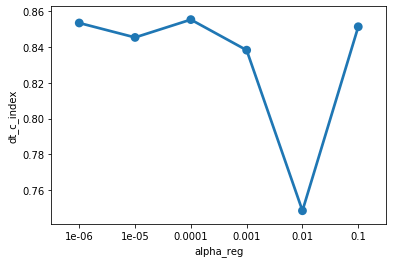

In [13]:
sns.pointplot(data=df, x='alpha_reg', y='dt_c_index')

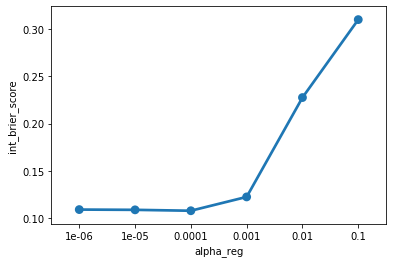

In [14]:
sns.pointplot(data=df, x='alpha_reg', y='int_brier_score')

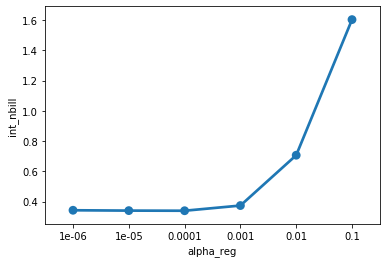

In [15]:
sns.pointplot(data=df, x='alpha_reg', y='int_nbill')

In [46]:
model_params = {
    'inp_shape': (None, 40),
    'val_n_ex_bin': 16716,
    'n_time_bins': 12,
    'n_ex_bin': 30,
    'n_epochs': 30,
    'seed': 5,
    'time_grid': np.linspace(1, np.max(data['val']['t']), 30, dtype=np.int),
    'alpha_bias_random_mean': 10.0,
    'alpha_random_stddev': 5.0,
    'beta_random_stddev': 5.0,
    'units_layers': [64, 32, 16],
    'dropout': 0
}
# alpha_reg = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
alpha_reg = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
params = ParameterGrid({'alpha_reg': alpha_reg})

In [47]:
def test_model(train_data, test_data, model_params):
    kkbox_main_network_current = partial(kkbox_main_network, units_in_layers=model_params['units_layers'], dropout=model_params['dropout'])
    model = WeibullModel(input_shape=model_params['inp_shape'], seed=model_params['seed'],
                         main_network=kkbox_main_network_current, alpha_reg=model_params['alpha_reg'],
                         alpha_bias_random_mean=model_params['alpha_bias_random_mean'], 
                         alpha_random_stddev=model_params['alpha_random_stddev'], 
                         beta_random_stddev=model_params['beta_random_stddev'])
    
    step_rate = 10
    decay = 0.9
    global_step = tf.Variable(0, trainable=False)
    increment_global_step = tf.assign(global_step, global_step + 1)
    learning_rate = tf.train.exponential_decay(0.001, global_step, step_rate, decay, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    train = optimizer.minimize(model.loss)
    
    # data to test
    dg = DataGenerator(x=test_data['x'], y=test_data['y'], t=test_data['t'], n_ex_bin=model_params['val_n_ex_bin'],
                                  n_time_bins=model_params['n_time_bins'])
    x_batch_test_val, y_batch_test_val, target_test_val = next(dg.get_batch())
    dg = DataGenerator(x=train_data['x'], y=train_data['y'], t=train_data['t'], n_ex_bin=model_params['val_n_ex_bin'],
                                  n_time_bins=model_params['n_time_bins'])
    x_batch_test_train, y_batch_test_train, target_test_train = next(dg.get_batch())
    
    # train data
    dg = DataGenerator(x=train_data['x'], y=train_data['y'], t=train_data['t'], n_ex_bin=model_params['n_ex_bin'], 
                                  n_time_bins=model_params['n_time_bins'])
    all_lr = []
    hist_losses_train = []
    hist_losses_val = []
    all_pred_train = []
    all_pred_val = []
    with tf.device('/GPU:0'):
        with tf.Session() as sess:
            tf.set_random_seed(model_params['seed'])
            init = tf.initialize_all_variables()
            sess.run(init)
            # for each epoch
            for i in tqdm(range(model_params['n_epochs'])):
                # initialize generator
                gen = dg.get_batch()
                while True:
                    try:
                        # get batch data
                        x_batch, y_batch, target = next(gen)
                        feed_dict = {
                            model.x: x_batch,
                            model.t: y_batch[:, 0].reshape((y_batch[:, 0].shape[0], 1)),
                            model.y: y_batch[:, 1].reshape((y_batch[:, 0].shape[0], 1)),
                            model.target: target.reshape((y_batch[:, 0].shape[0], 1)),
                        }
                        # train model
                        _, l = sess.run([train, model.loss], feed_dict=feed_dict)
                    except StopIteration:
                        break
                # prediction at val
                pred = sess.run(model.o1, feed_dict={model.x: test_data['x']})
                l = sess.run(model.loss, feed_dict={
                    model.x: x_batch_test_val,
                    model.t: y_batch_test_val[:, 0].reshape((y_batch_test_val[:, 0].shape[0], 1)),
                    model.y: y_batch_test_val[:, 1].reshape((y_batch_test_val[:, 0].shape[0], 1)),
                    model.target: target_test_val.reshape((y_batch_test_val[:, 0].shape[0], 1))
                })
                all_pred_val.append(pred)
                hist_losses_val.append(l)
                # prediction at train
                pred = sess.run(model.o1, feed_dict={model.x: train_data['x']})
                l = sess.run(model.loss, feed_dict={
                    model.x: x_batch_test_train,
                    model.t: y_batch_test_train[:, 0].reshape((y_batch_test_train[:, 0].shape[0], 1)),
                    model.y: y_batch_test_train[:, 1].reshape((y_batch_test_train[:, 0].shape[0], 1)),
                    model.target: target_test_train.reshape((y_batch_test_train[:, 0].shape[0], 1))
                })
                all_pred_train.append(pred)
                hist_losses_train.append(l)     
                print(l)
                sess.run(increment_global_step)

    return hist_losses_train, hist_losses_val, all_pred_train, all_pred_val


In [48]:
every_nth_epoch = 3

# all_res_quality = []

train_data = data['train']
test_data = data['test']

for par in tqdm(params):
    tf.reset_default_graph()
    par.update(model_params)
    train_loss, val_loss, pred_train, pred_val = test_model(train_data=train_data, test_data=test_data, model_params=par)
    pred_to_estimate = pred_val[::every_nth_epoch]
    all_q = []
    for idx, pred in enumerate(pred_to_estimate):
        q = test_quality(t_true=test_data['t'], y_true=test_data['y'], pred=pred, time_grid=model_params['time_grid'], concordance_at_t=None, plot=False)
        q['epoch'] = every_nth_epoch * idx
        all_q.append(q)
    q = pd.concat(all_q)
    q.reset_index(drop=True, inplace=True)
    q['test_loss'] = ''
    q['train_loss'] = ''
    q.at[0, 'test_loss'] = val_loss
    q.at[0, 'train_loss'] = train_loss
    q['alpha_reg'] = par['alpha_reg']
    all_res_quality.append(q)
    print(all_res_quality)
    with open('../../output/kkbox_weibull_alpha_sgd.pkl', 'wb') as f:
        pickle.dump(all_res_quality, f)

1.4102676
1.3986247
1.3932856
1.3892761
1.3861995
1.3843944
1.3820996
1.3806026
1.379784
1.3785467
1.3774402
1.3764726
1.3760538
1.3753818
1.3746276
1.3740988
1.3737061
1.3728653
1.3727248
1.3722554
1.3715402
1.3713464
1.371128
1.3705444
1.3706234
1.3706123
1.3699011
1.3695422
1.3693628
1.3690369

[   dt_c_index  int_brier_score  int_nbill  epoch  \
0    0.835619         0.125176   0.386376      0   
1    0.845261         0.120095   0.373108      3   
2    0.847644         0.118476   0.368148      6   
3    0.849476         0.117844   0.366395      9   
4    0.849977         0.117628   0.365537     12   
5    0.850595         0.116834   0.363228     15   
6    0.850945         0.116928   0.363442     18   
7    0.851392         0.116710   0.363010     21   
8    0.851890         0.116414   0.362320     24   
9    0.852094         0.116493   0.362117     27   

                                           test_loss  \
0  [1.3976939, 1.3859955, 1.3818048, 1.377306, 1....   
1              

1.4572966
1.4461095
1.4409224
1.4364271
1.4332865
1.4314476
1.4295875
1.4282349
1.4275796
1.4262533
1.4254204
1.4247068
1.4241714
1.4236746
1.4230186
1.4226074
1.4220879
1.4214582
1.421264
1.4210031
1.4203538
1.4200577
1.4199032
1.4195694
1.419917
1.4196048
1.4190571
1.4187657
1.4185332
1.4182591

[   dt_c_index  int_brier_score  int_nbill  epoch  \
0    0.835619         0.125176   0.386376      0   
1    0.845261         0.120095   0.373108      3   
2    0.847644         0.118476   0.368148      6   
3    0.849476         0.117844   0.366395      9   
4    0.849977         0.117628   0.365537     12   
5    0.850595         0.116834   0.363228     15   
6    0.850945         0.116928   0.363442     18   
7    0.851392         0.116710   0.363010     21   
8    0.851890         0.116414   0.362320     24   
9    0.852094         0.116493   0.362117     27   

                                           test_loss  \
0  [1.3976939, 1.3859955, 1.3818048, 1.377306, 1....   
1              

1.7060627
1.6943275
1.6889443
1.6856686
1.6829604
1.681381
1.6796873
1.6781174
1.6773545
1.6761656
1.6751534
1.6745232
1.6737179
1.6737256
1.6729376
1.6725647
1.6723474
1.671583
1.6712073
1.670788
1.6703607
1.6701607
1.6699256
1.6697474
1.6695215
1.6697257
1.668938
1.6688266
1.6685536
1.6683162

[   dt_c_index  int_brier_score  int_nbill  epoch  \
0    0.835619         0.125176   0.386376      0   
1    0.845261         0.120095   0.373108      3   
2    0.847644         0.118476   0.368148      6   
3    0.849476         0.117844   0.366395      9   
4    0.849977         0.117628   0.365537     12   
5    0.850595         0.116834   0.363228     15   
6    0.850945         0.116928   0.363442     18   
7    0.851392         0.116710   0.363010     21   
8    0.851890         0.116414   0.362320     24   
9    0.852094         0.116493   0.362117     27   

                                           test_loss  \
0  [1.3976939, 1.3859955, 1.3818048, 1.377306, 1....   
1                

34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345
34.94345



KeyboardInterrupt: 

In [9]:
import seaborn as sns

In [49]:
with open('../../output/kkbox_weibull_alpha_sgd.pkl', 'rb') as f:
    df = pickle.load(f)

In [52]:
df = pd.concat(df)

In [54]:
df.head()

,dt_c_index,int_brier_score,int_nbill,epoch,test_loss,train_loss,alpha_reg
0,0.835619,0.125176,0.386376,0,"[1.3976939, 1.3859955, 1.3818048, 1.377306, 1....","[1.4040823, 1.3920465, 1.3875285, 1.3830898, 1...",0.000001
1,0.845261,0.120095,0.373108,3,,,0.000001
2,0.847644,0.118476,0.368148,6,,,0.000001
3,0.849476,0.117844,0.366395,9,,,0.000001
4,0.849977,0.117628,0.365537,12,,,0.000001


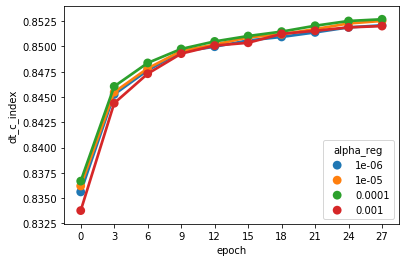

In [55]:
sns.pointplot(x=df['epoch'], y=df['dt_c_index'], hue=df['alpha_reg'])

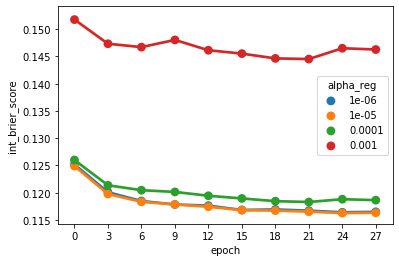

In [56]:
sns.pointplot(x=df['epoch'], y=df['int_brier_score'], hue=df['alpha_reg'])

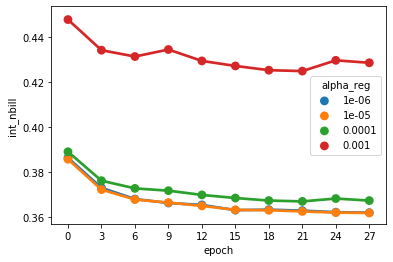

In [57]:
sns.pointplot(x=df['epoch'], y=df['int_nbill'],hue=df['alpha_reg'])

In [58]:
df1 = df[df['alpha_reg'] < 1e-3]

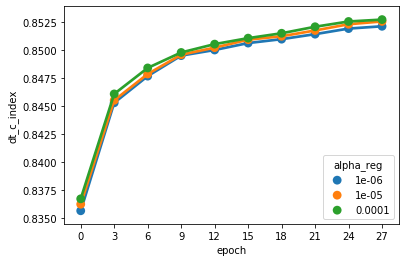

In [61]:
sns.pointplot(x=df1['epoch'], y=df1['dt_c_index'],hue=df1['alpha_reg'])

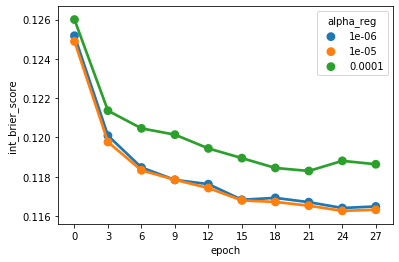

In [60]:
sns.pointplot(x=df1['epoch'], y=df1['int_brier_score'],hue=df1['alpha_reg'])

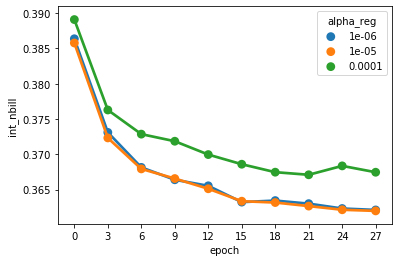

In [59]:
sns.pointplot(x=df1['epoch'], y=df1['int_nbill'],hue=df1['alpha_reg'])

### Learning rate range test

In [65]:
model_params = {
    'n_ex_bin': n_ex_bin,
    'n_time_bins': n_time_bins, 
    'time_grid': time_grid,
    'inp_shape': inp_shape,
    'n_epochs': 60,
    'n_batches': 20,
    'learning_rate': 0.0001,
    'alpha_reg': 0.001,
    'dropout': 0,
    'units_layers_options': [32, 16]
}

In [66]:
kkbox_main_network_current = partial(kkbox_main_network, units_in_layers=model_params['units_layers_options'], dropout=model_params['dropout'])
model = WeibullModel(model_params['inp_shape'], main_network=kkbox_main_network_current, seed=5, alpha_reg=model_params['alpha_reg'])

dg = ContrastiveDataGenerator(x=data['train']['x'], y=data['train']['y'], t=data['train']['t'], n_ex_bin=model_params['n_ex_bin'],
                              n_time_bins=model_params['n_time_bins'])


def generate_feed_dict(gen):
    x_batch, y_batch, sample_weight, target = next(gen)
    return {
        model.x: x_batch,
        model.t: y_batch[:, 0].reshape((y_batch[:, 0].shape[0], 1)),
        model.y: y_batch[:, 1].reshape((y_batch[:, 0].shape[0], 1)),
        model.target: target.reshape((y_batch[:, 0].shape[0], 1)),
        model.sample_weight: sample_weight
    }

In [67]:
def learning_rate_range_test(model, dg, generate_feed_dict, model_params):
    
    n_batches = model_params['n_batches']
    n_epochs = model_params['n_epochs']
    all_lr = []
    step_rate = 1
    decay = 1.1
    global_step = tf.Variable(0, trainable=False)
    increment_global_step = tf.assign(global_step, global_step + 1)
    learning_rate = tf.train.exponential_decay(model_params['learning_rate'], global_step, step_rate, decay, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    
    train = optimizer.minimize(model.loss)
    
    train_loss = []
    val_loss = []
    # Launch the graph
    with tf.device('/GPU:0'):
        with tf.Session() as sess:
            tf.compat.v1.set_random_seed(s)
            init = tf.initialize_all_variables()
            sess.run(init)
            for i in tqdm(range(n_epochs)):
                gen = dg.get_batch()
                for j in range(n_batches):
                    try:
                        feed_dict = generate_feed_dict(gen)
                        _, l = sess.run([train, model.loss], feed_dict=feed_dict)
                        train_loss.append(l)
                        new_lr = sess.run(optimizer._learning_rate_tensor)
                        all_lr.append(new_lr)
                    except StopIteration:
                        break               
                sess.run(increment_global_step)
    return train_loss, all_lr


In [68]:
train_loss, all_lr = learning_rate_range_test(model, dg, generate_feed_dict, model_params)

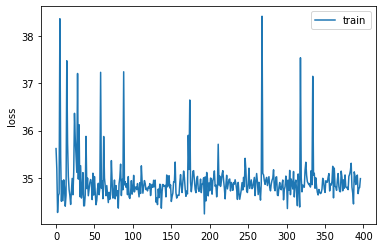

In [89]:
plt.plot(train_loss[3:400], label='train')
plt.ylabel('loss')
plt.legend(loc=0)
plt.show()

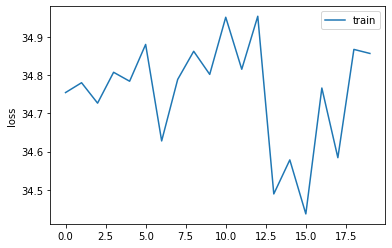

In [81]:
start_ind = 120
end_ind = 140
plt.plot(train_loss[start_ind:end_ind], label='train')
plt.ylabel('loss')
plt.legend(loc=0)
plt.show()

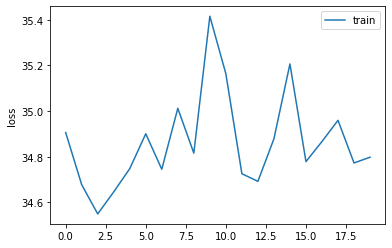

In [87]:
start_ind = 240
end_ind = 260
plt.plot(train_loss[start_ind:end_ind], label='train')
plt.ylabel('loss')
plt.legend(loc=0)
plt.show()

In [117]:
q = test_quality(t_true=data['val']['t'], y_true=data['val']['y'], pred=pred_1,
                 time_grid=np.array([  1,  28,  56,  84, 113, 141, 169, 197, 226, 254, 282, 311, 339,
                                     367, 395, 424, 452, 480, 508, 537, 565, 593, 622, 650, 678, 706,735, 763, 791, 820]), concordance_at_t=424, plot=True)

In [128]:
q['epoch'] = 30
all_q = [q]

for m in [5, 10, 15, 20, 25]:
    q = test_quality(t_true=data['val']['t'], y_true=data['val']['y'], pred=all_pred[m-1],
                 time_grid=np.array([  1,  28,  56,  84, 113, 141, 169, 197, 226, 254, 282, 311, 339,
                                     367, 395, 424, 452, 480, 508, 537, 565, 593, 622, 650, 678, 706,735, 763, 791, 820]), concordance_at_t=424, plot=True)
    q['epoch'] = m
    all_q.append(q)

df_all_q = pd.concat(all_q).sort_values('epoch')

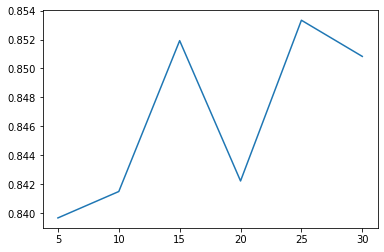

In [129]:
plt.plot(df_all_q['epoch'], df_all_q['dt_c_index'])

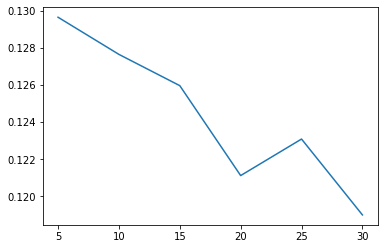

In [130]:
plt.plot(df_all_q['epoch'], df_all_q['int_brier_score'])

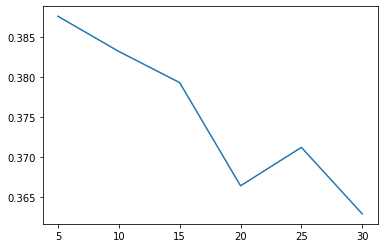

In [131]:
plt.plot(df_all_q['epoch'], df_all_q['int_nbill'])